In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
plt.rcParams['figure.figsize'] = (10,10)

In [3]:
import seaborn as sns

Set Seeds

In [4]:
import tensorflow as tf

In [5]:
seed = 7531
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
import matplotlib

In [7]:
np.where(np.linspace(-0.5,0.5,1001) == 0)

(array([500], dtype=int64),)

In [8]:
gnbu_b = plt.get_cmap("GnBu")(np.linspace(-0.5,0.5,1001))
gnbu_b[500,:] = np.array([0.,0.,0.,1.])
cmap = matplotlib.colors.ListedColormap(gnbu_b)

### PyTorch

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

In [12]:
class Net(nn.Module):

    def __init__(self, input_size):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.fc_in = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 300)
        self.fc3 = nn.Linear(300, 100)
        self.fc_out = nn.Linear(100,10) 

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.fc_in(x))
        # If the size is a square you can only specify a single number
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc_out(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net(input_size=28*28)
print(net)

Net(
  (fc_in): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=100, bias=True)
  (fc_out): Linear(in_features=100, out_features=10, bias=True)
)


In [13]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

8
torch.Size([500, 784])


In [17]:
transform = transforms.Compose(
    [])

trainset = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = (0,1,2,3,4,5,6,7,8,9)

In [5]:
dataiter = iter(trainloader)
img, label = dataiter.next()

In [9]:
img.shape

torch.Size([4, 1, 28, 28])

In [8]:
img.view(img.shape[0], -1).shape

torch.Size([4, 784])

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:


dataiter = iter(testloader)
images, labels = dataiter.next()

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))



GroundTruth:      7     2     1     0


In [26]:
outputs = net(images.view(images.shape[0], -1))
torch.max(outputs,axis=1)

C:\Users\Nils\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.return_types.max(
values=tensor([0.1108, 0.1105, 0.1086, 0.1111], grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 1]))

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

### Tensorflow

In [9]:
import tensorflow as tf
from tensorflow.keras import layers

Masking: https://stackoverflow.com/questions/38278965/selectively-zero-weights-in-tensorflow

In [113]:
class Linear(layers.Layer):
    
    def __init__(self,input_dim=32,units=32, mask=False, mask_matrix=None):
        super(Linear,self).__init__()
        
        self.units = units
        self.input_dim = input_dim
        
        if mask:
            if mask_matrix == None:
                #select random mask
                self.mask = tf.constant(np.random.randint(2, size=(input_dim, units)).astype("float32"))
            else:
                self.mask = tf.constant(mask_matrix.astype("float32"))
        else:
            self.mask = tf.constant(np.ones((input_dim,units), dtype="float32"))
        
        init_w = tf.random_normal_initializer()
        init_b = tf.zeros_initializer()
        
        self.w = tf.Variable(initial_value=init_w(shape=(input_dim, units),dtype='float32'),trainable=True)
        self.b = tf.Variable(initial_value=init_b(shape=(units,),dtype='float32'),trainable=True)
    
    def set_mask_rand(self):
        self.mask = tf.constant(np.random.randint(2, size=(input_dim, units)).astype("float32"))
    
    def set_mask(self,mask):
        self.mask = tf.constant(mask.astype("float32"))
    
    def get_mask(self):
        return self.mask
    
    def reset_mask(self):
        self.mask = tf.constant(np.ones(input_dim, units), dtype="float32")
        
    def get_masked_weights(self):
        return tf.multiply(self.w, self.mask)
    
    def get_nonzero_weights(self):
        weights_masked = tf.multiply(self.w, self.mask)
        mask = tf.not_equal(weights_masked, 0)
        return weights_masked[mask]

    def call(self, inputs):
        w_mask = tf.multiply(self.w, self.mask)
        return tf.matmul(inputs, w_mask) + self.b

In [54]:
x = tf.ones((2, 2))
linear_layer = Linear(2,1, mask=True)
y = linear_layer(x)
print(y)


tf.Tensor(
[[-0.09556624]
 [-0.09556624]], shape=(2, 1), dtype=float32)


In [55]:
import tensorflow_datasets as tfds

In [56]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [57]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    #print(image.shape)
    print(tf.reshape(image, [tf.shape(image)[0]*tf.shape(image)[1]]).shape)
    print(tf.one_hot(label,10).shape)
    return tf.cast(tf.reshape(image, [tf.shape(image)[0]*tf.shape(image)[1]]), tf.float32) / 255., tf.one_hot(label,10)

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.shuffle(ds_info.splits['train'].num_examples)
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

(784,)
(10,)
(784,)
(10,)


In [58]:
def initialize_weights(dist, shape, mu=0, sigma=1):
    if dist == "std_normal":
        return np.random.randn(*shape)
    if dist == "normal":
        return mu + sigma*np.random.randn(*shape)
    if dist == "zeros":
        return np.zeros(shape)
    if dist == "ones":
        return np.ones(shape)

In [59]:
def set_weights_man(model, layers=None):
    i = 0
    len_model = len(model.layers)
    initial_weights = []
    
    if layers == None:
        for l in model.layers:
            W = initialize_weights("normal", [l.input_dim, l.units], sigma=0.05)
            b = initialize_weights("zeros", [l.units])
            initial_weights.append([W,b])
            l.set_weights([W,b])
    else:
        for i,l in enumerate(model.layers):
            if i in layers:
                W = initialize_weights("normal", [l.input_dim, l.units], sigma=0.05)
                b = initialize_weights("zeros", [l.units])
                initial_weights.append([W,b])
                l.set_weights([W,b])
            else:
                continue
    
    return model, initial_weights

In [114]:
class FCN(tf.keras.Model):
    
    def __init__(self, input_dim):
        super(FCN,self).__init__()
        self.linear_in = Linear(input_dim,input_dim)
        self.linear_h1 = Linear(input_dim,500)
        self.linear_h2 = Linear(500,300)
        self.linear_h3 = Linear(300,100)
        self.linear_out = Linear(100,10)
    
    def call(self, inputs):
        x = self.linear_in(inputs)
        x = tf.nn.relu(x)
        x = self.linear_h1(x)
        x = tf.nn.relu(x)
        x = self.linear_h2(x)
        x = tf.nn.relu(x)
        x = self.linear_h3(x)
        x = tf.nn.relu(x)        
        x = self.linear_out(x)
        return tf.nn.softmax(x)

In [115]:
input_dim = iter(ds_train).next()[0].shape[1]
batch_size = iter(ds_train).next()[0].shape[0]

In [62]:
input_dim

784

In [116]:
fcn = FCN(input_dim)

In [21]:
initial_weights = [l.weights[0].numpy() for l in fcn.layers]

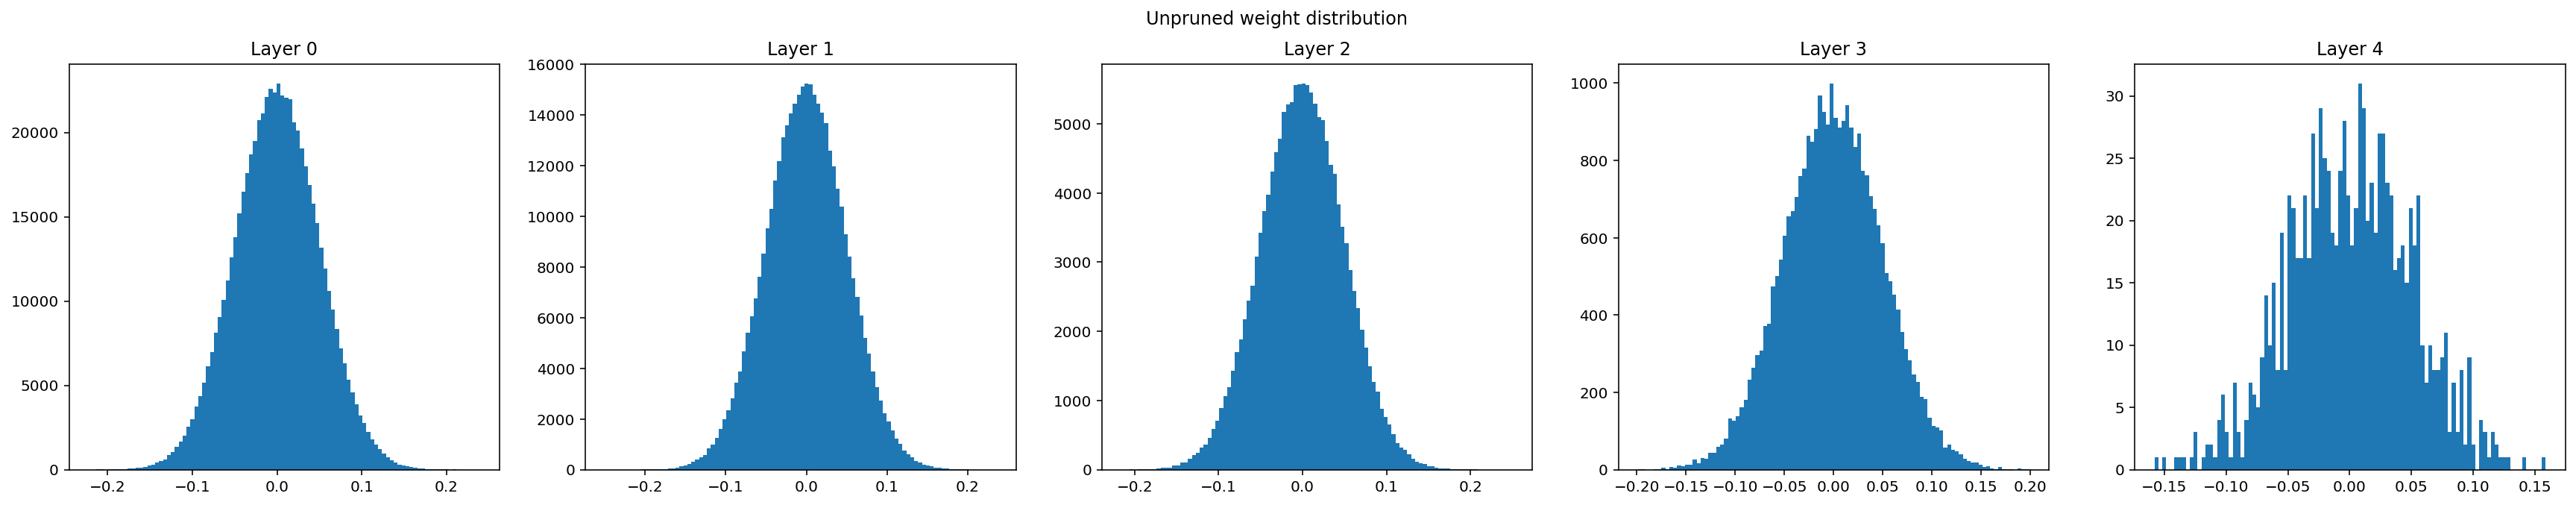

In [22]:
fig = plt.figure(figsize=(30,5))
fig.suptitle("Unpruned weight distribution")
for i,l in enumerate(fcn.layers):
    plt.subplot(1,5,i+1)
    plt.title(f"Layer {i}")
    _ = plt.hist(l.get_weights()[0].flatten(), bins=100)

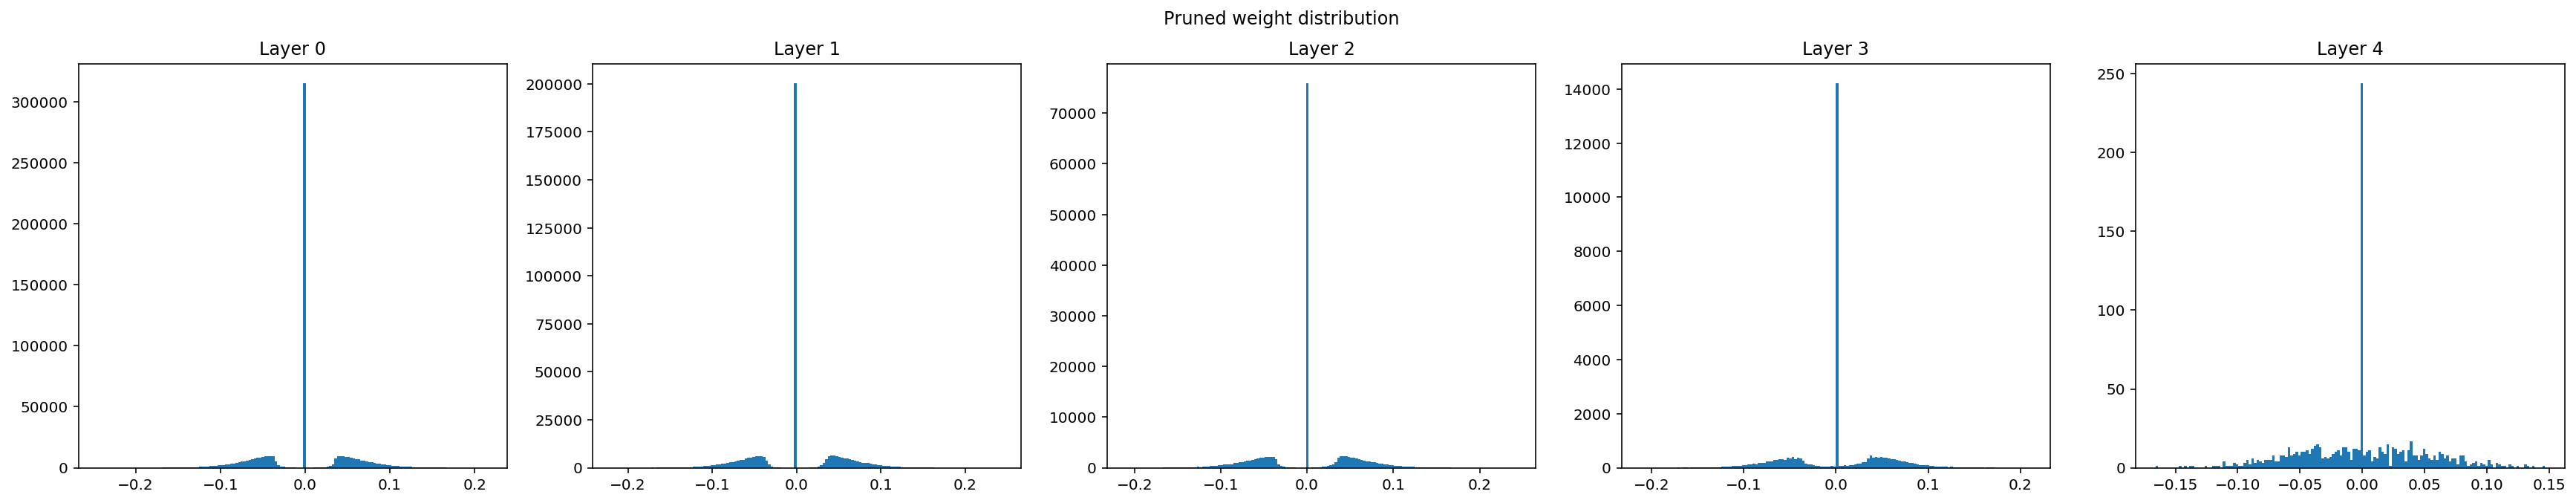

In [156]:
fig = plt.figure(figsize=(30,5))
fig.suptitle("Pruned weight distribution")
for i,l in enumerate(fcn.layers):
    plt.subplot(1,5,i+1)
    plt.title(f"Layer {i}")
    _ = plt.hist(l.get_masked_weights().numpy().flatten(), bins=150)

#_ = plt.hist(fcn.layers[0].get_masked_weights().numpy().flatten(), bins=100)

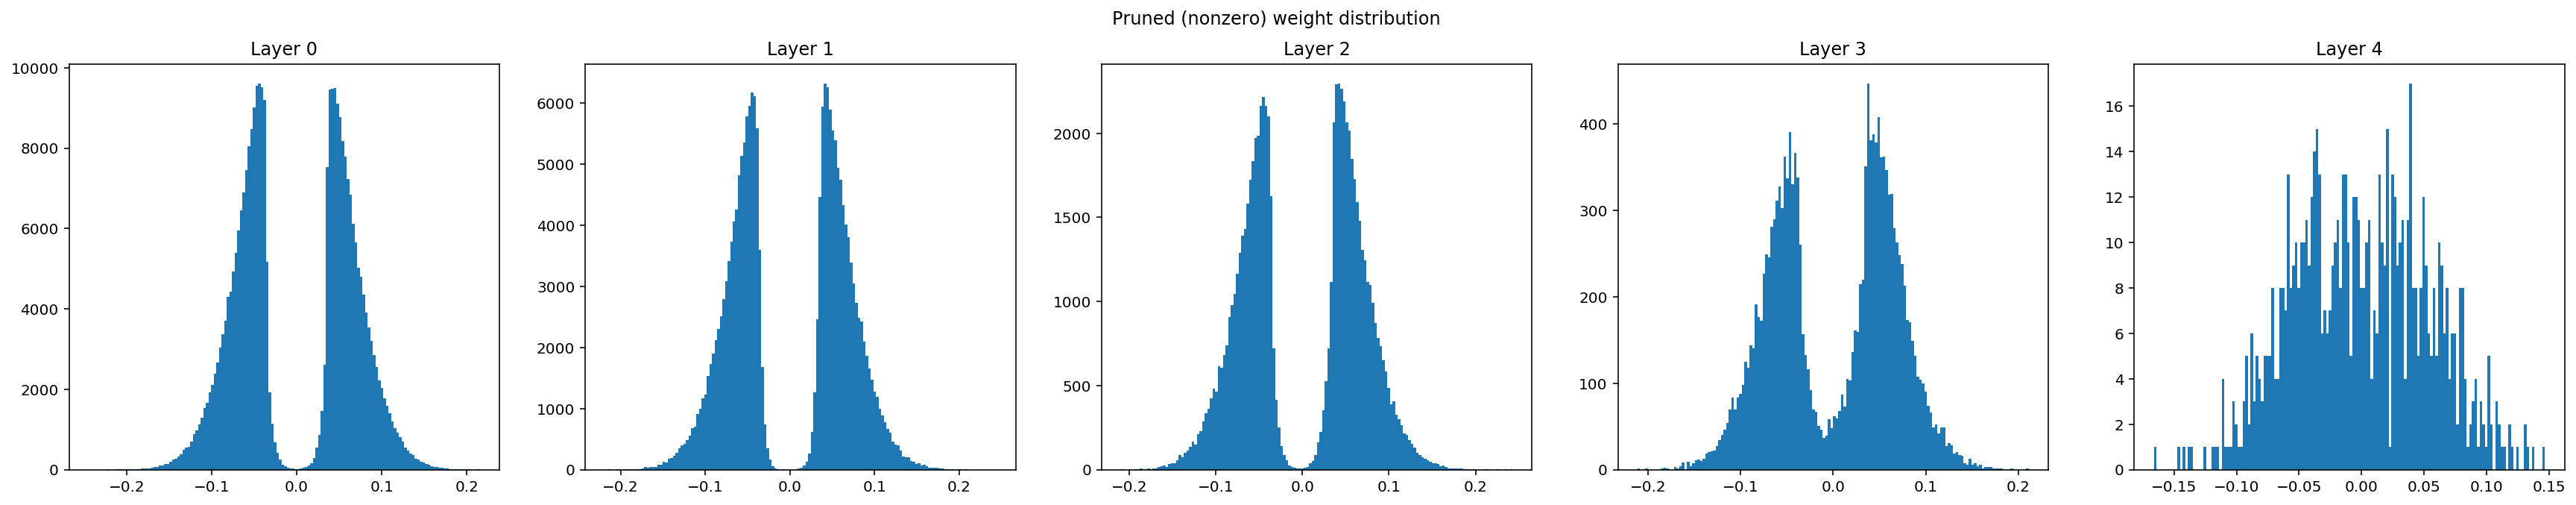

In [155]:
fig = plt.figure(figsize=(30,5))
fig.suptitle("Pruned (nonzero) weight distribution")
for i,l in enumerate(fcn.layers):
    plt.subplot(1,5,i+1)
    plt.title(f"Layer {i}")
    _ = plt.hist(l.get_nonzero_weights().numpy().flatten(), bins=150)

#_ = plt.hist(fcn.layers[0].get_masked_weights().numpy().flatten(), bins=100)

In [574]:
np.equal(fcn.layers[0].get_weights()[0],fcn.layers[0].get_masked_weights().numpy()).all()

True

In [117]:
fcn, initial_weights = set_weights_man(fcn)

In [173]:
for i,l in enumerate(fcn.layers):
    l.set_weights(initial_weights[i])
    #l.weights[0] = initial_weights[i][0]

In [50]:
np.mean(initial_weights[0][0] - fcn.layers[0].weights[0])

0.0

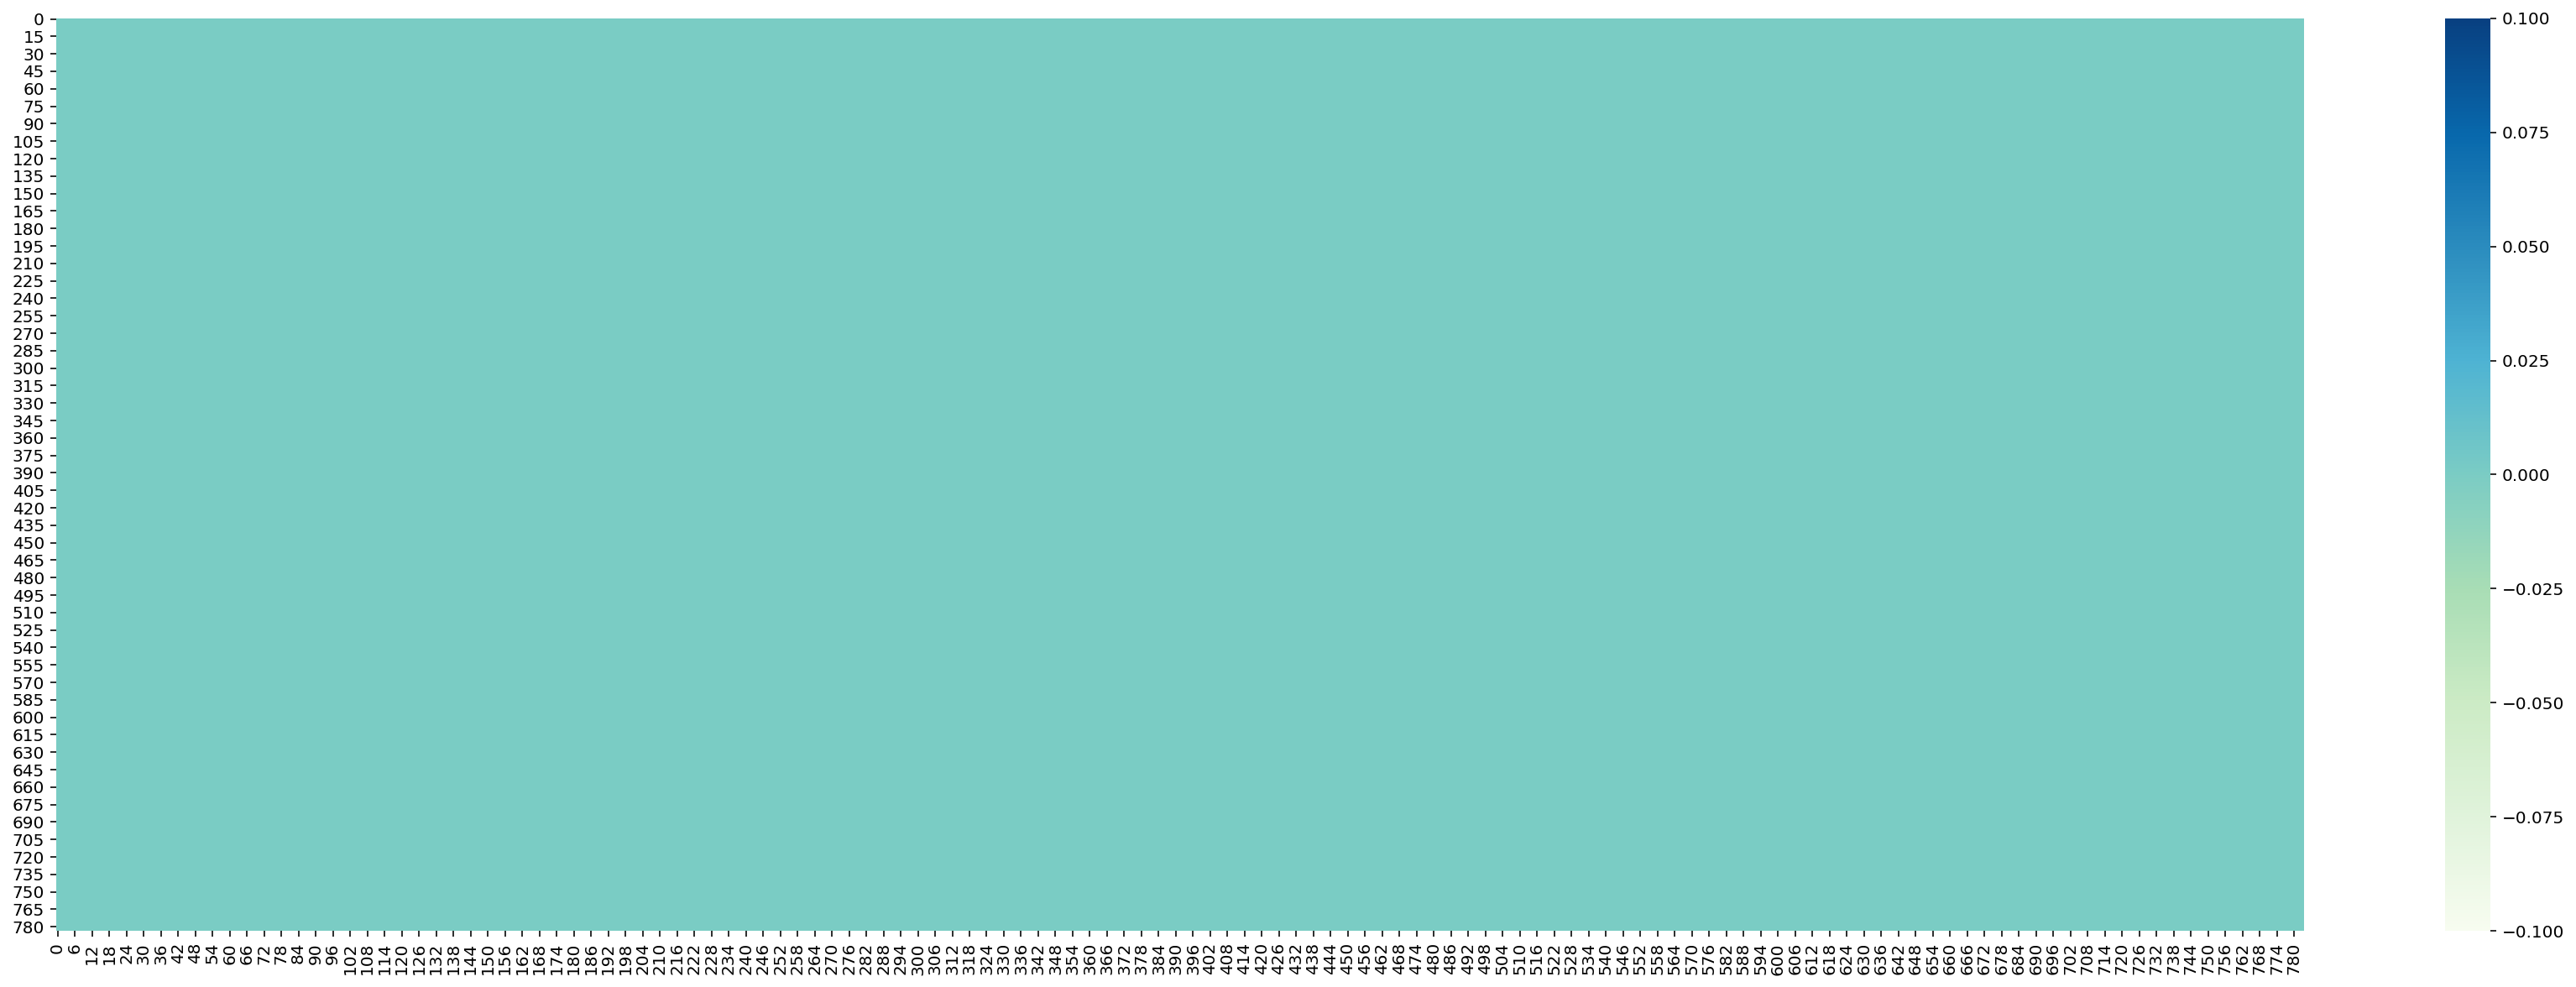

In [51]:
plt.figure(figsize=(30,10))
sns.heatmap(initial_weights[0][0] - fcn.layers[0].weights[0], cmap="GnBu")

In [97]:
for i,l in enumerate(fcn.layers):
    a = np.mean(initial_weights[i][0] - l.get_masked_weights())
    print(f"layer 1: {a}")

layer 1: 8.877714572008699e-05
layer 1: -0.00022741024440620095
layer 1: -0.0004929418209940195
layer 1: -0.0007177547086030245
layer 1: 0.0011860518716275692


In [384]:
for i,l in enumerate(fcn.layers):
    a = np.mean(initial_weights[i][0] - l.get_weights()[0])
    print(f"layer {i}: {a}")

layer 0: 0.0001405421982747834
layer 1: -0.000522469607457697
layer 2: -0.0011903249881008604
layer 3: -0.0030908669201987118
layer 4: -7.691849107346881e-08


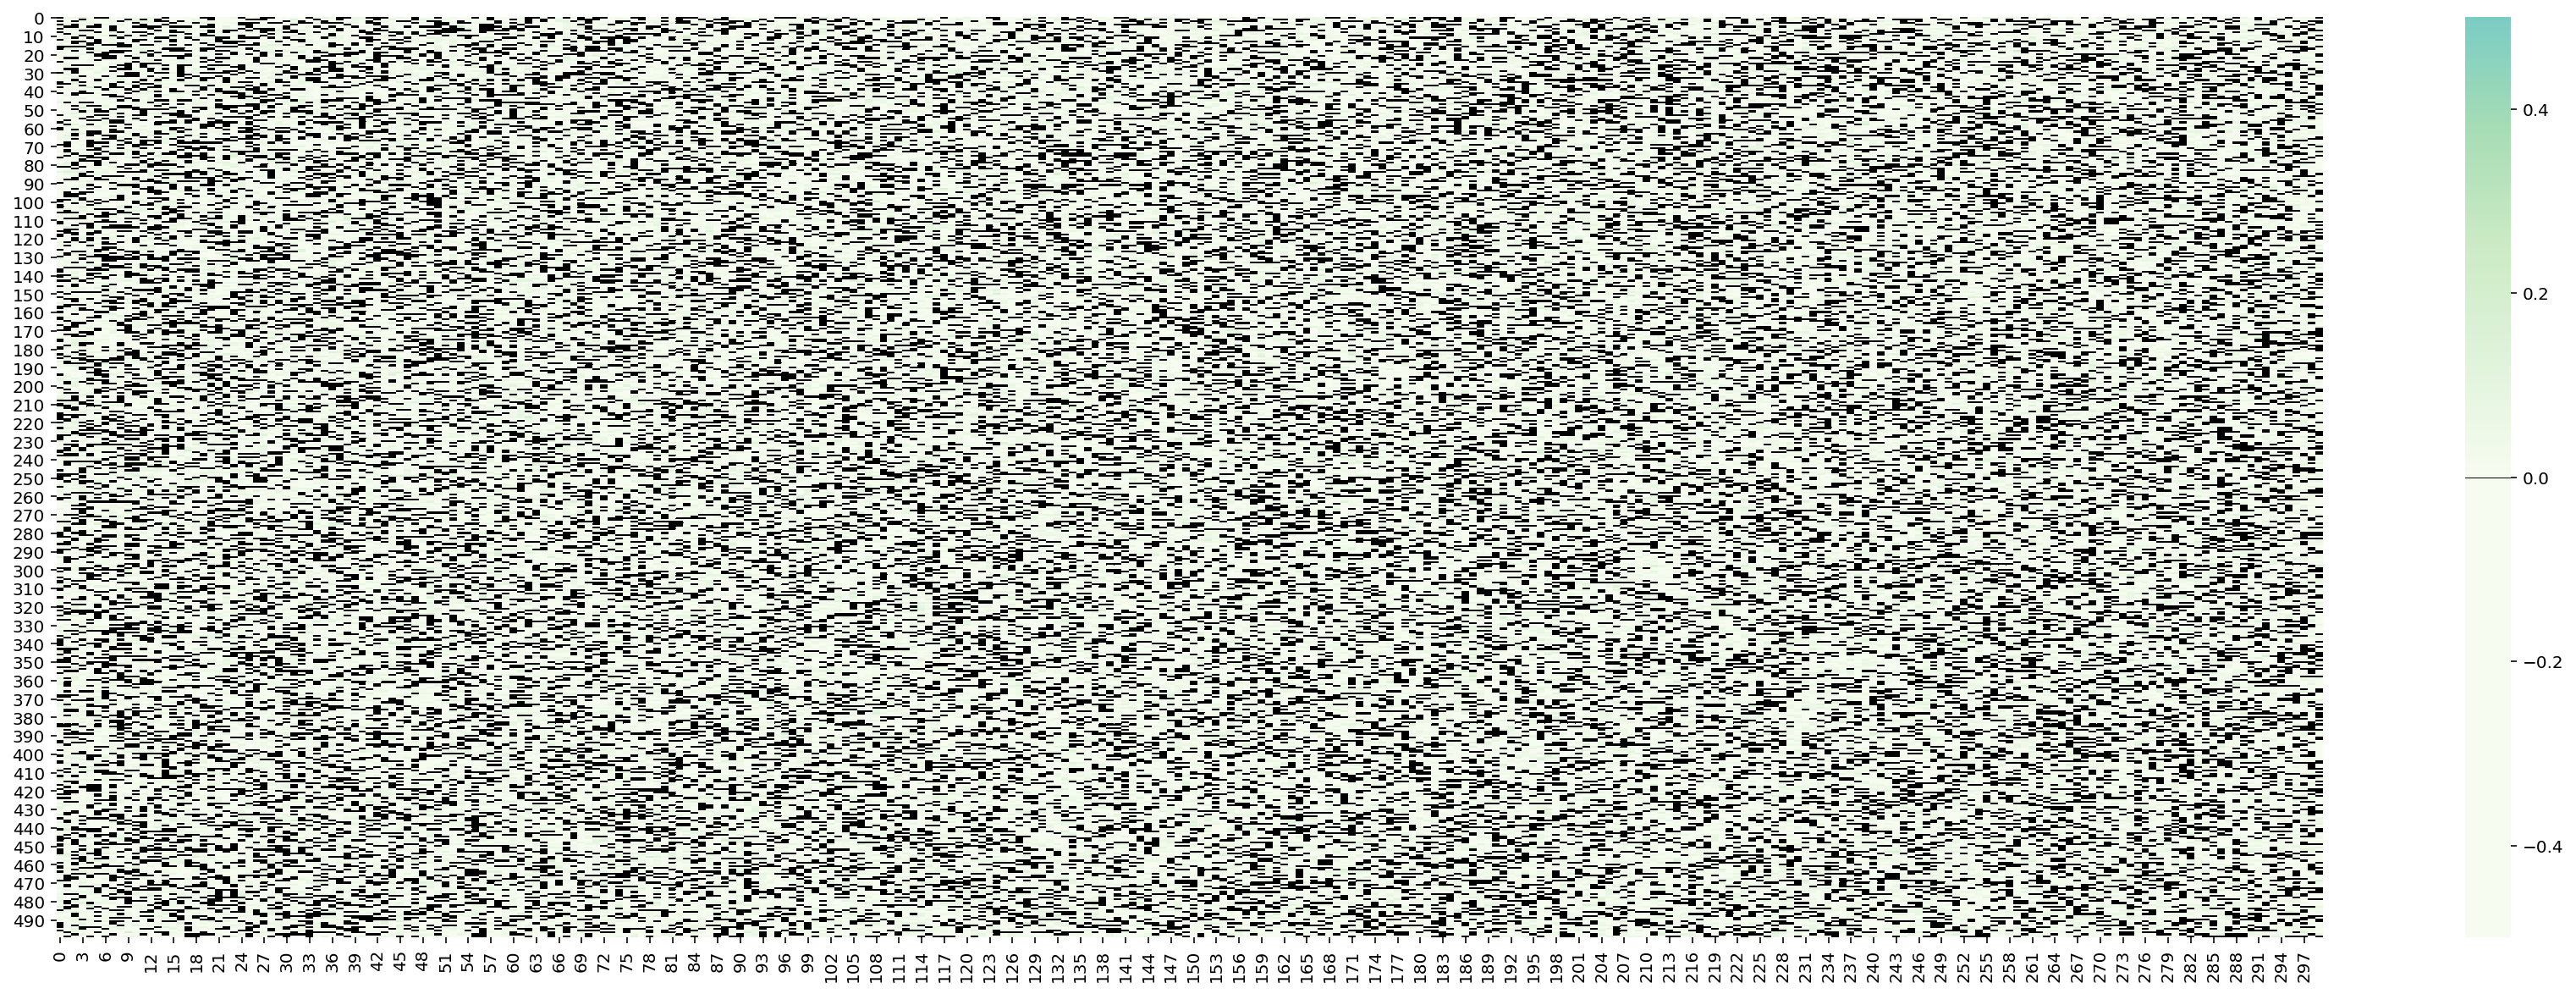

In [133]:
plt.figure(figsize=(30,10))
sns.heatmap(fcn.layers[2].get_masked_weights(), cmap=cmap, vmin=-0.5, vmax=0.5)

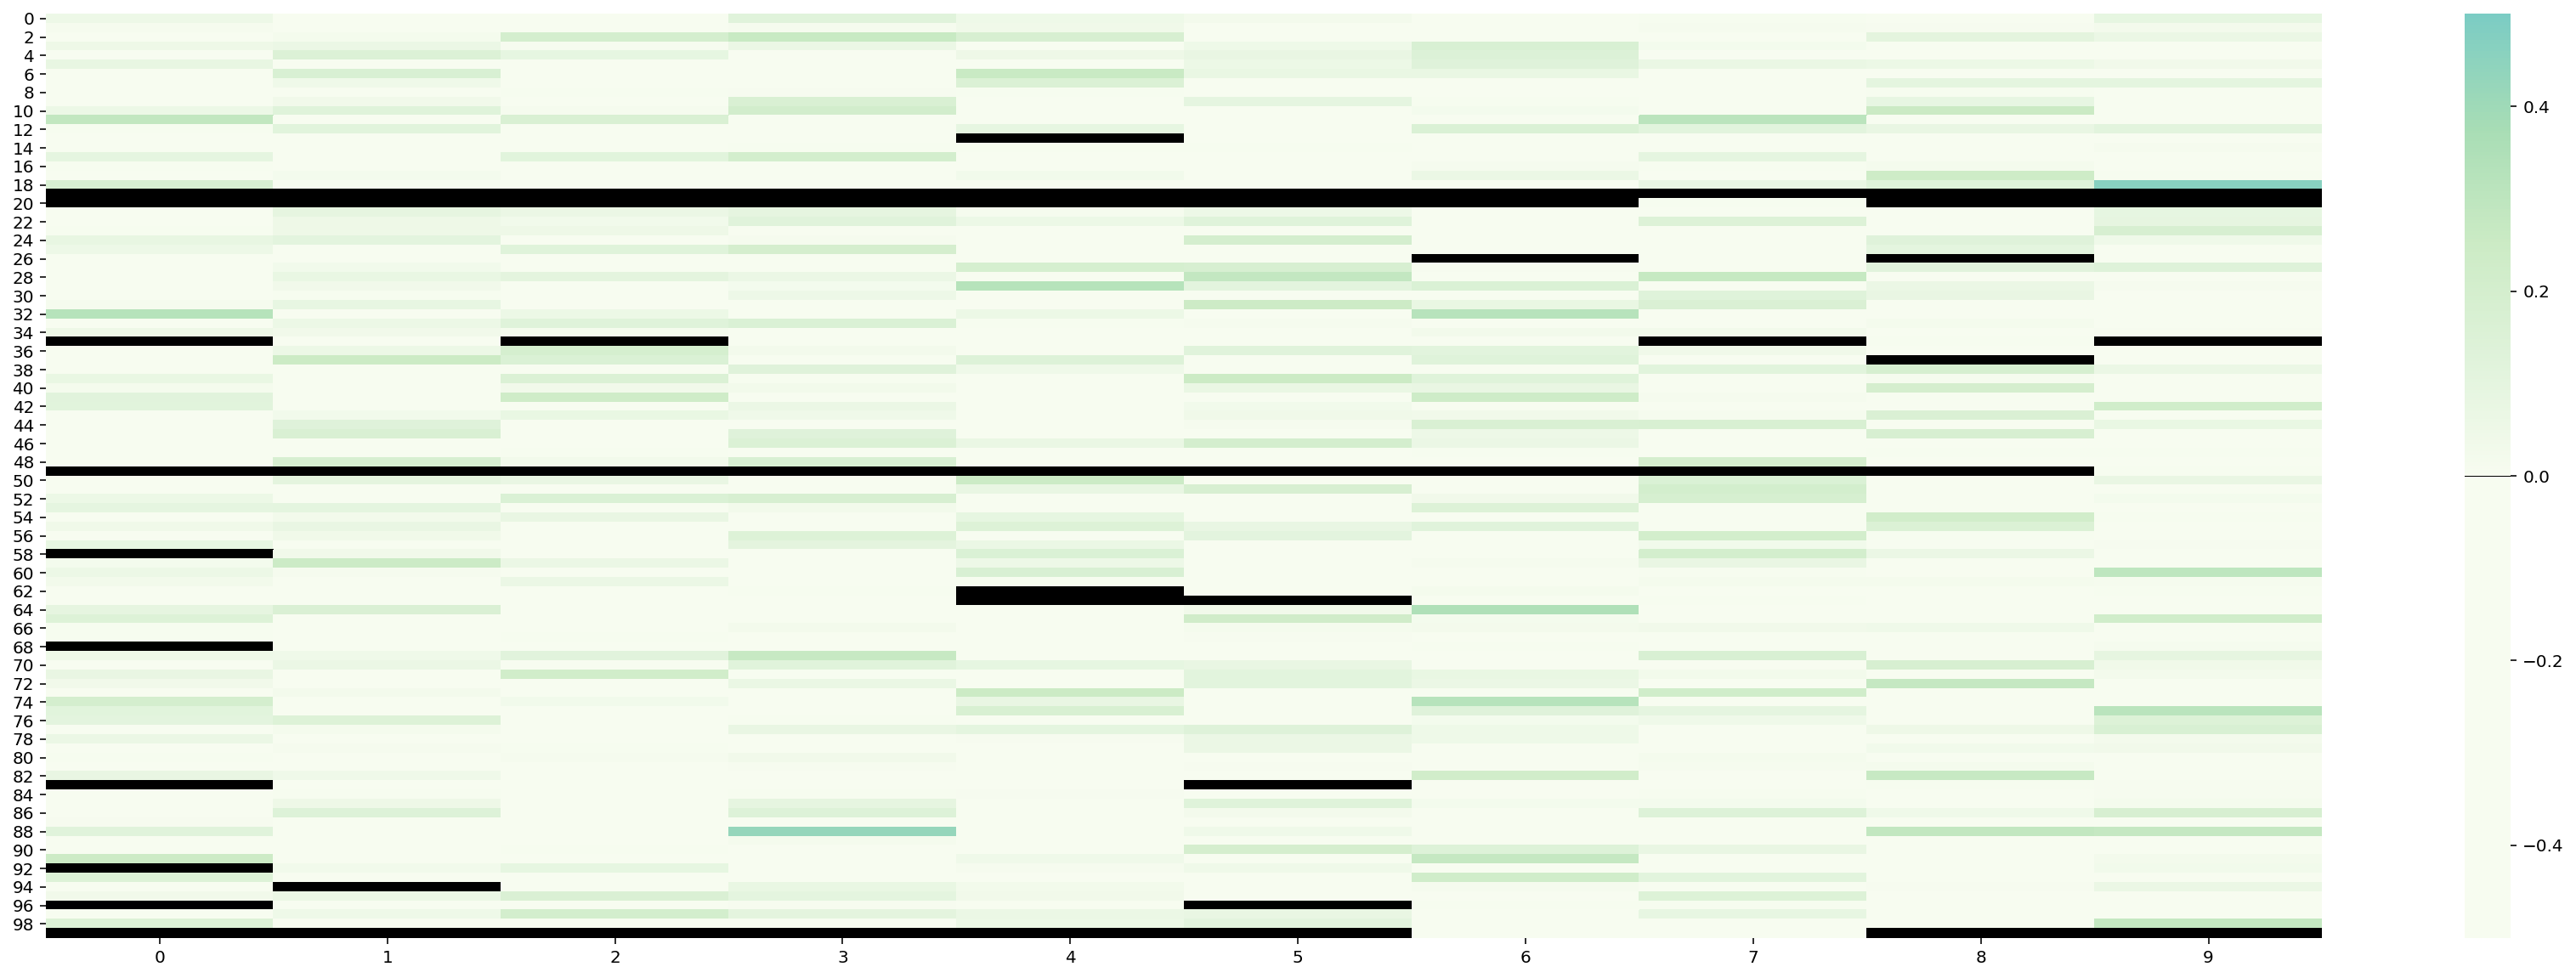

In [381]:
plt.figure(figsize=(30,10))
sns.heatmap(initial_weights[4][0] - fcn.layers[4].get_masked_weights(), cmap=cmap, vmin=-0.5, vmax=0.5)

In [67]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [68]:
loss_metric = tf.keras.metrics.Mean()
acc_metric = tf.keras.metrics.CategoricalAccuracy()

In [69]:
[w[0].shape for w in initial_weights]

[(784, 784), (784, 500), (500, 300), (300, 100), (100, 10)]

In [118]:
total_epochs = 0

In [176]:
epochs = 5
all_weights = [] #+ [w[0] for w in initial_weights]
all_weights_pruned = []
all_weights_nonzero = []
all_weights.append([w[0] for w in initial_weights])
all_weights_pruned.append([l.get_masked_weights().numpy() for l in fcn.layers])
all_weights_nonzero.append([l.get_nonzero_weights().numpy() for l in fcn.layers])

# Iterate over epochs.
for epoch in range(epochs):
    
    print(f"Start of epoch {epoch}  ---  Total Epochs: {total_epochs}")
    total_epochs += 1
    # Iterate over the batches of the dataset.
    for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
        with tf.GradientTape() as tape:
            predicted = fcn(x_batch_train)
            # Compute reconstruction loss
            loss = loss_fn(y_batch_train, predicted)
            #loss += sum(fcn.losses)
        
        grads = tape.gradient(loss, fcn.trainable_weights)
        optimizer.apply_gradients(zip(grads, fcn.trainable_weights))

        loss_metric(loss)
        acc_metric(y_batch_train,predicted)
        
        #if step % 100 == 0:
    all_weights.append([w.numpy() for w in fcn.trainable_weights[::2]])
    all_weights_pruned.append([l.get_masked_weights().numpy() for l in fcn.layers])
    all_weights_nonzero.append([l.get_nonzero_weights().numpy() for l in fcn.layers])

    print('Accuracy = %s --- Mean loss = %s' % (acc_metric.result().numpy(),loss_metric.result().numpy()))

            

Start of epoch 0  ---  Total Epochs: 15
Accuracy = 0.961409 --- Mean loss = 0.1468769
Start of epoch 1  ---  Total Epochs: 16
Accuracy = 0.9619574 --- Mean loss = 0.1445171
Start of epoch 2  ---  Total Epochs: 17
Accuracy = 0.9627226 --- Mean loss = 0.14146501
Start of epoch 3  ---  Total Epochs: 18
Accuracy = 0.96358275 --- Mean loss = 0.13809879
Start of epoch 4  ---  Total Epochs: 19
Accuracy = 0.9645067 --- Mean loss = 0.13460645


In [177]:
[len(w) for w in all_weights]

[5, 5, 5, 5, 5, 5]

In [178]:
eval_acc = tf.keras.metrics.CategoricalAccuracy()
eval_loss_mean = tf.keras.metrics.Mean()
for x_batch_test, y_batch_test in ds_test:
    eval_pred = fcn(x_batch_test)
    eval_loss = loss_fn(y_batch_test, eval_pred)
    
    eval_loss_mean(eval_loss)
    eval_acc(y_batch_test, eval_pred)

print(f"Evaluation Loss: {eval_loss_mean.result().numpy()}")
print(f"Evaluation Accuracy: {eval_acc.result().numpy()}")

Evaluation Loss: 0.08165736496448517
Evaluation Accuracy: 0.9760000109672546


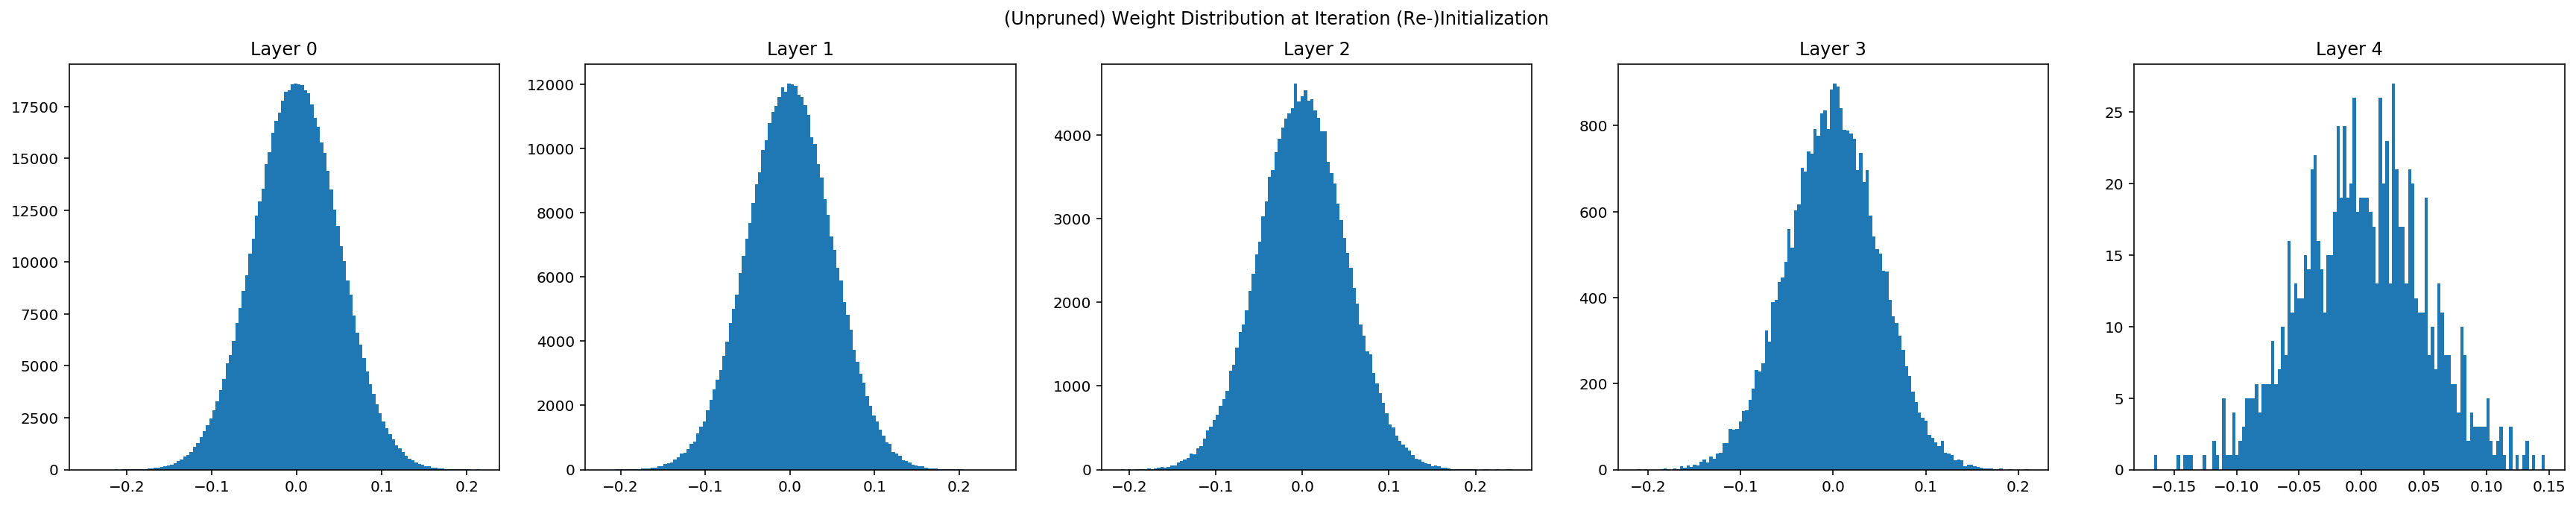

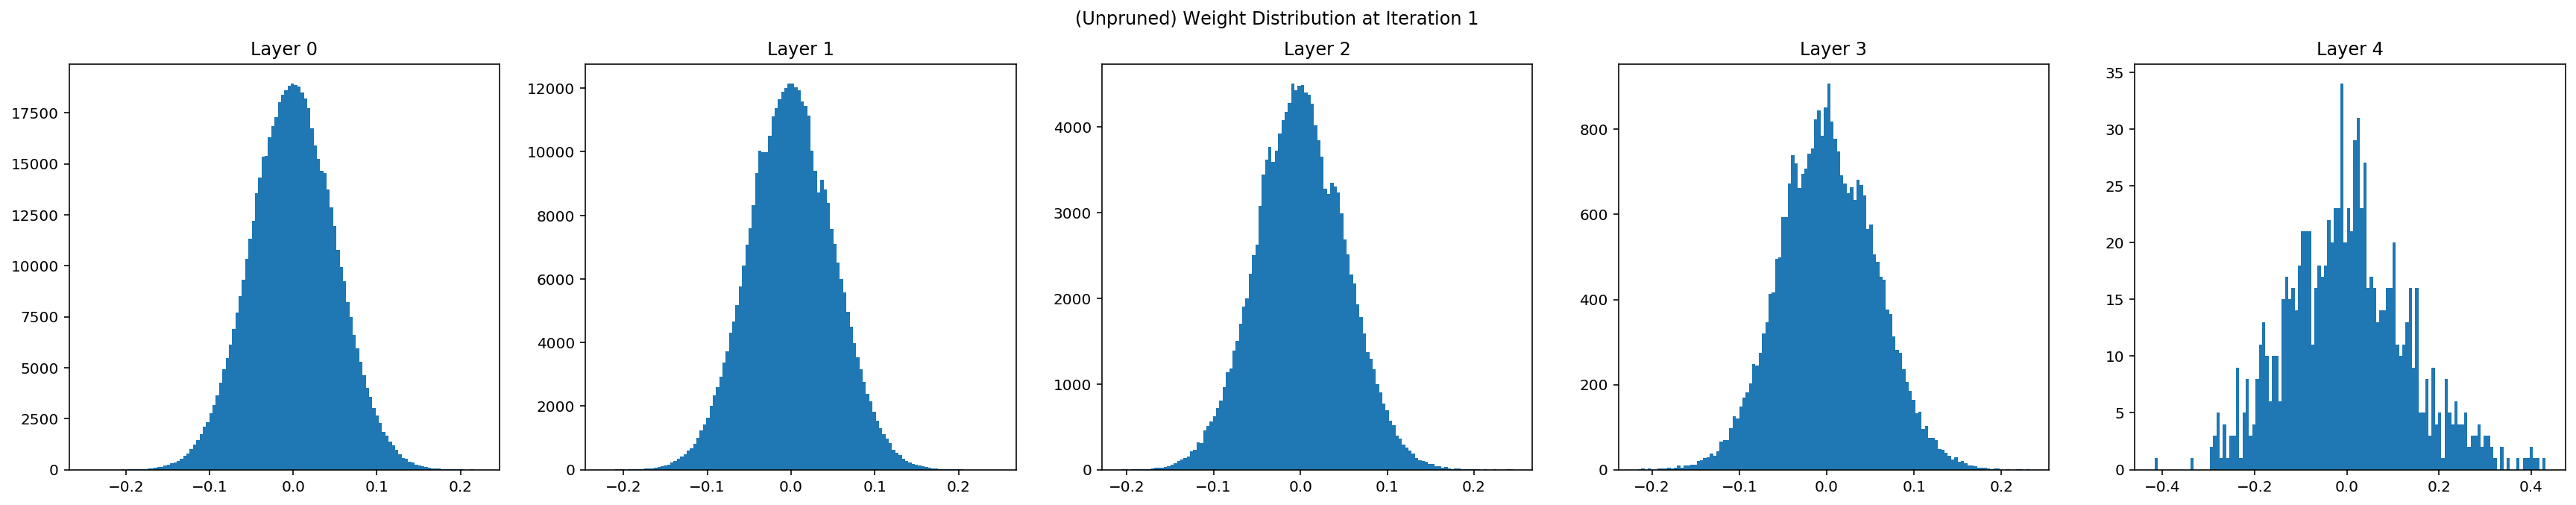

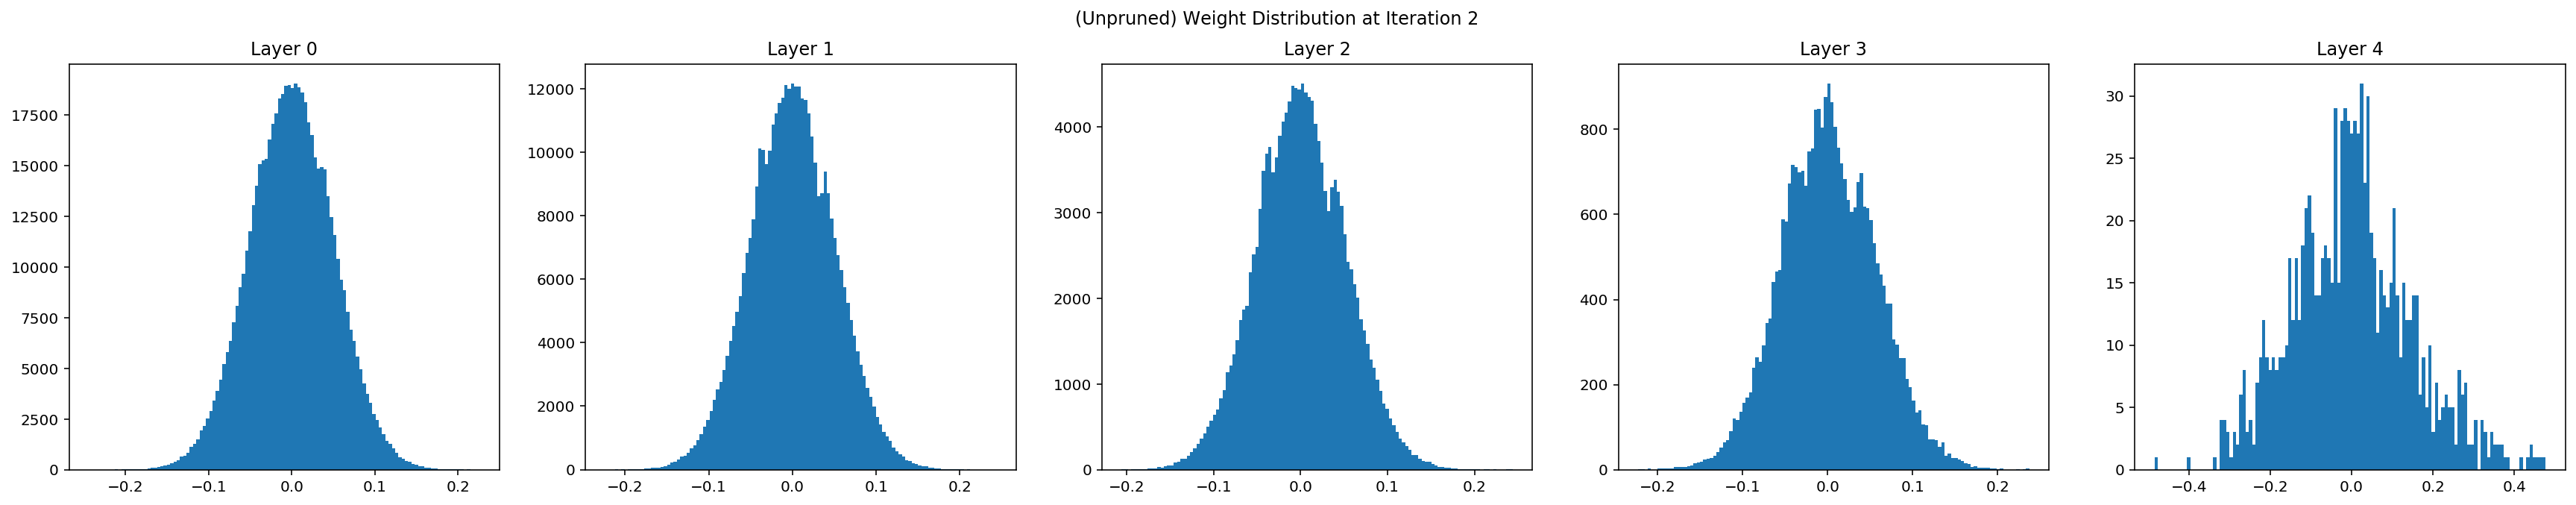

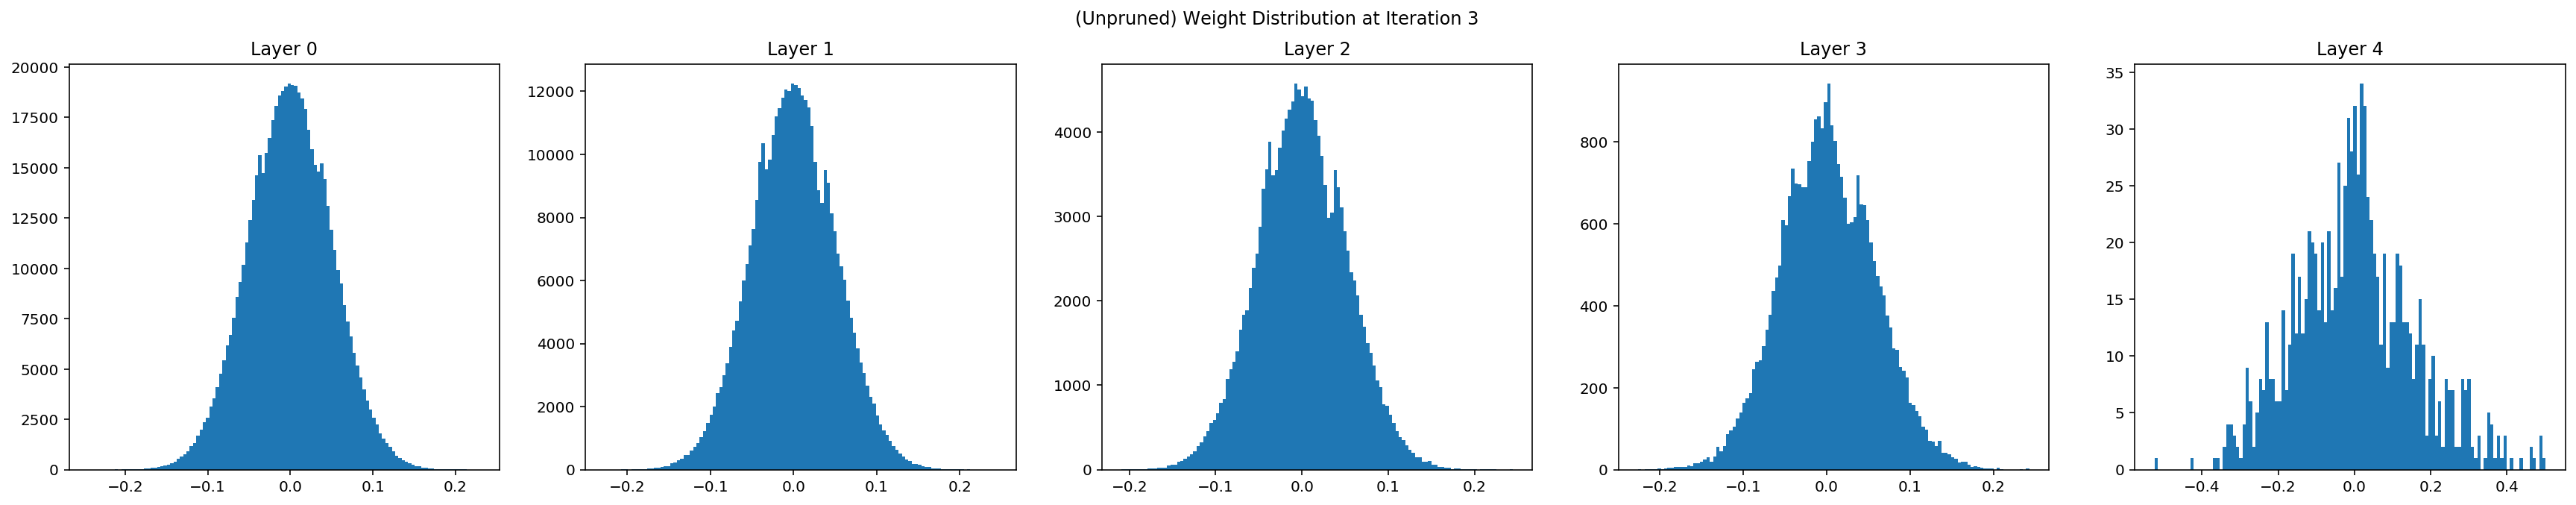

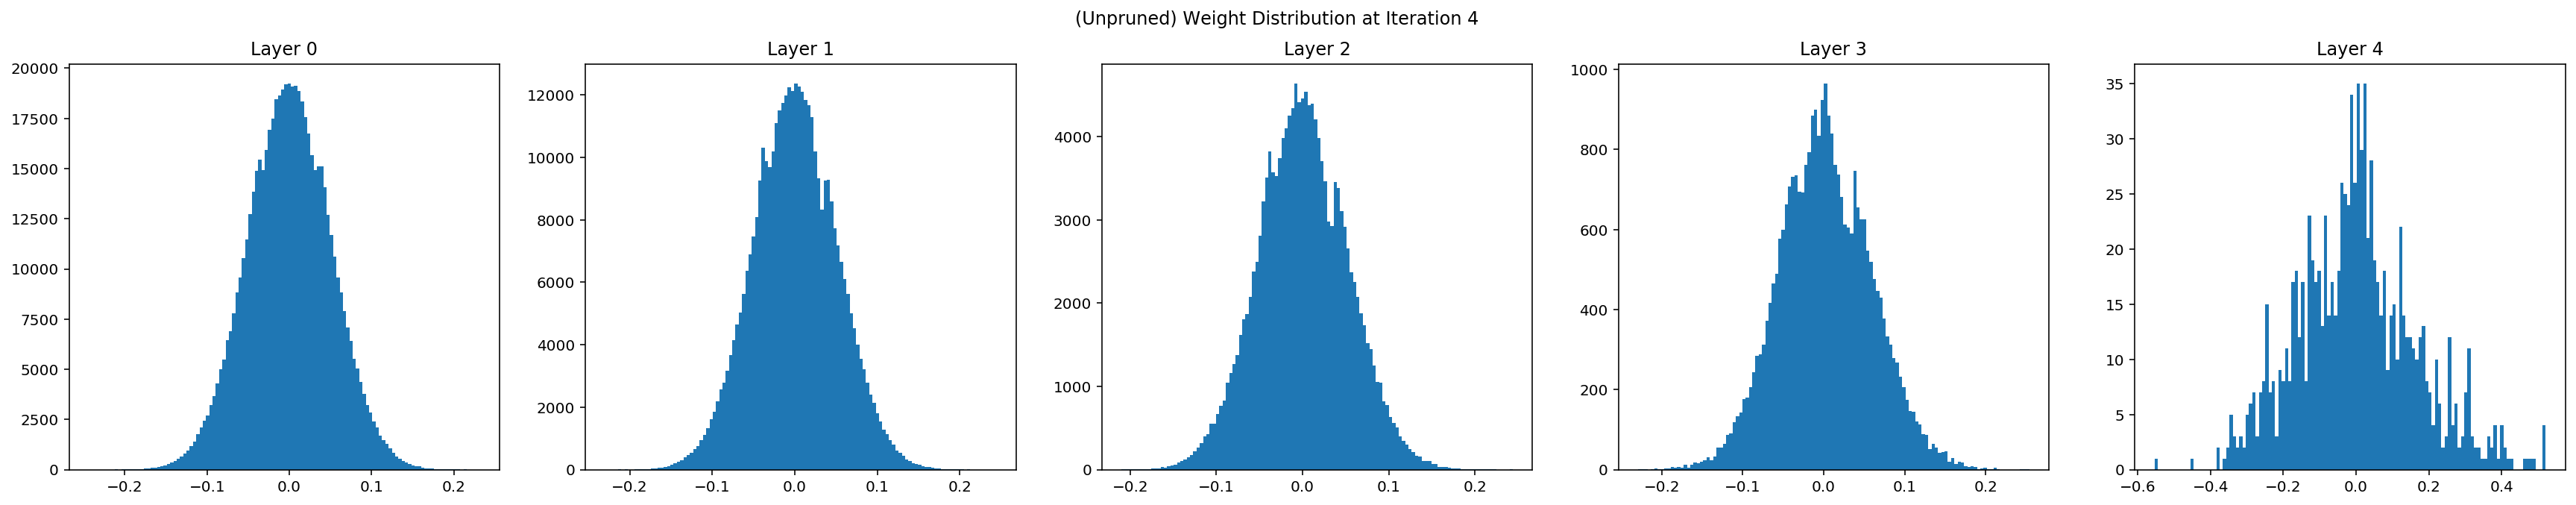

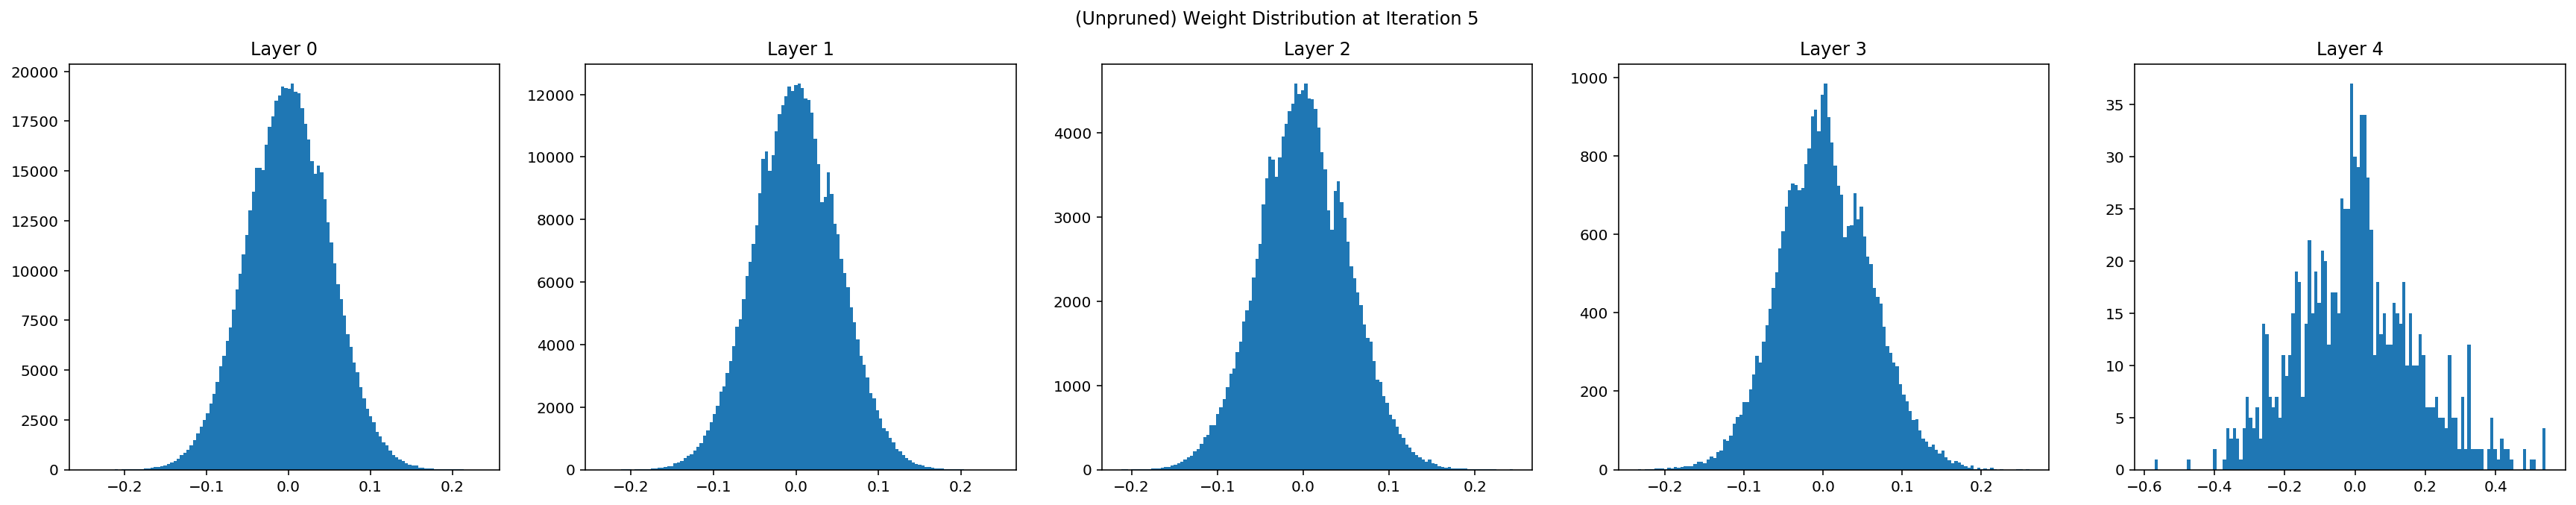

In [159]:
for i,all_weights_iter in enumerate(all_weights):
    fig = plt.figure(figsize=(30,5))
    if i == 0:
        fig.suptitle("(Unpruned) Weight Distribution at Iteration (Re-)Initialization")
    else:
        fig.suptitle(f"(Unpruned) Weight Distribution at Iteration {i}")
    for j,all_weights_layer in enumerate (all_weights_iter):
        plt.subplot(1,5,j+1)
        plt.title(f"Layer {j}")
        _ = plt.hist(all_weights_layer.flatten(), bins=120)

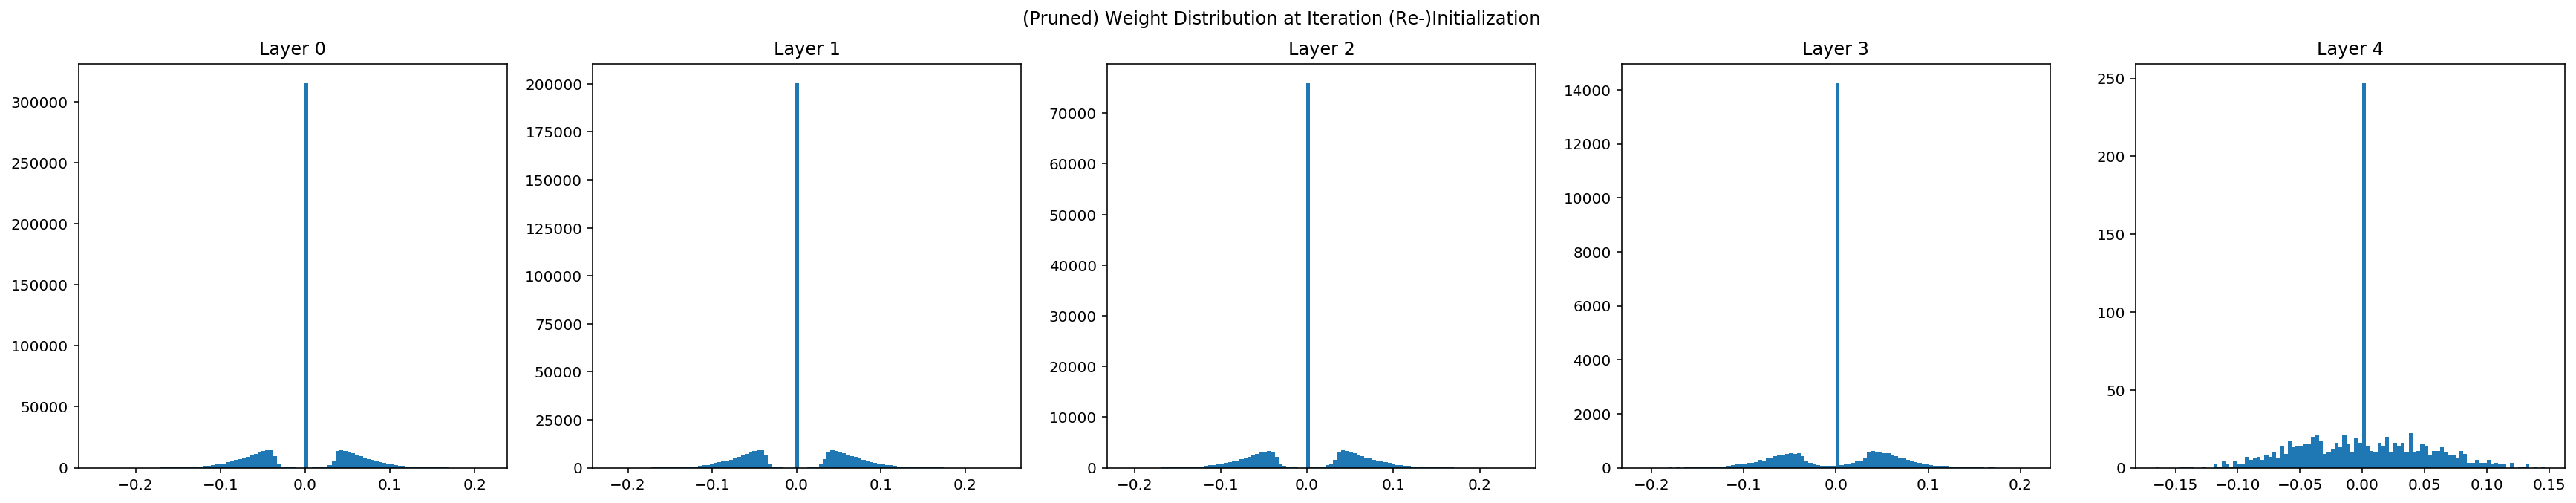

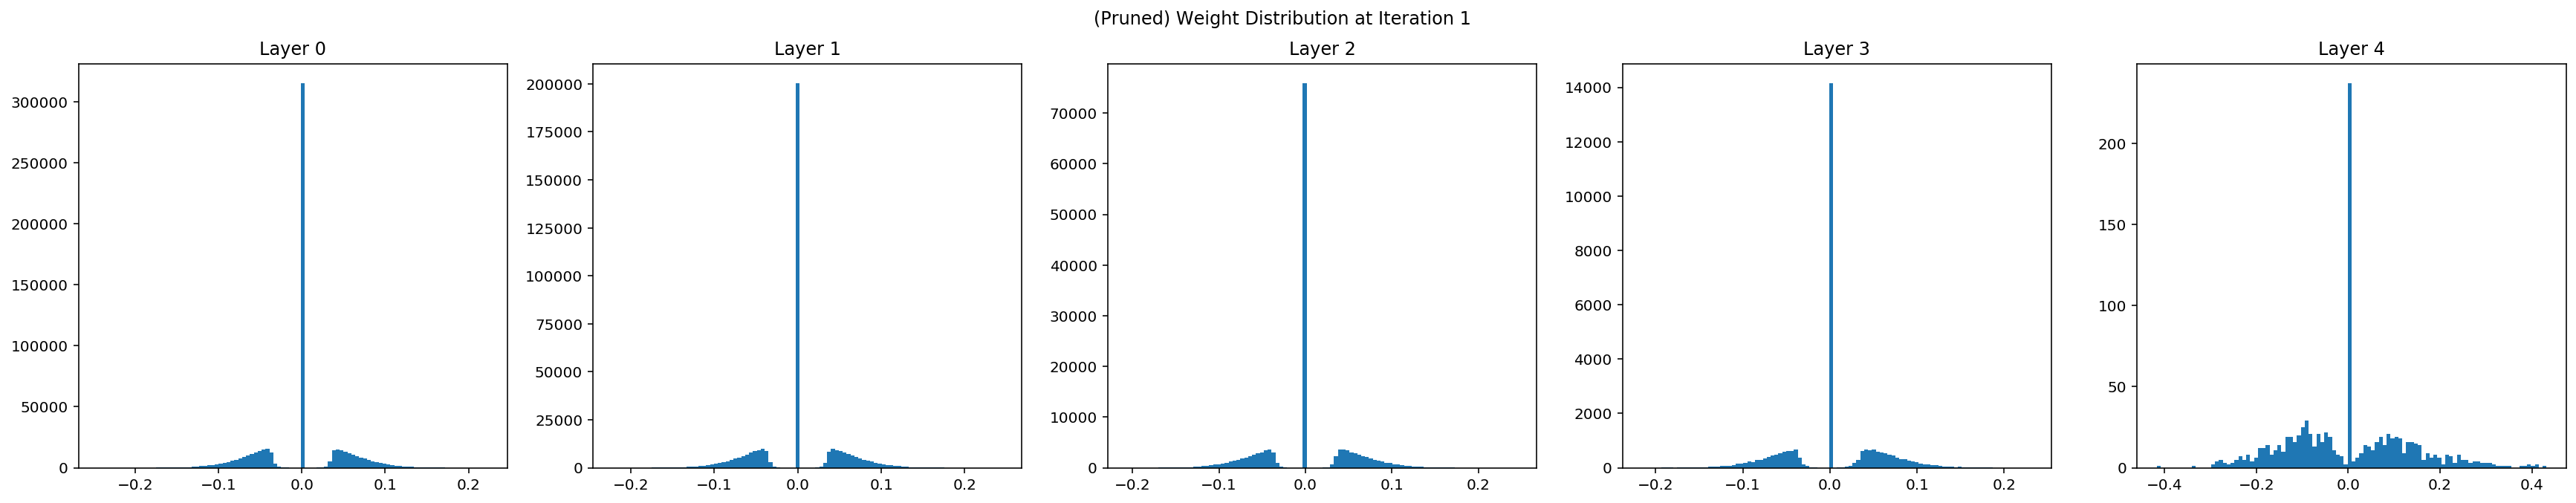

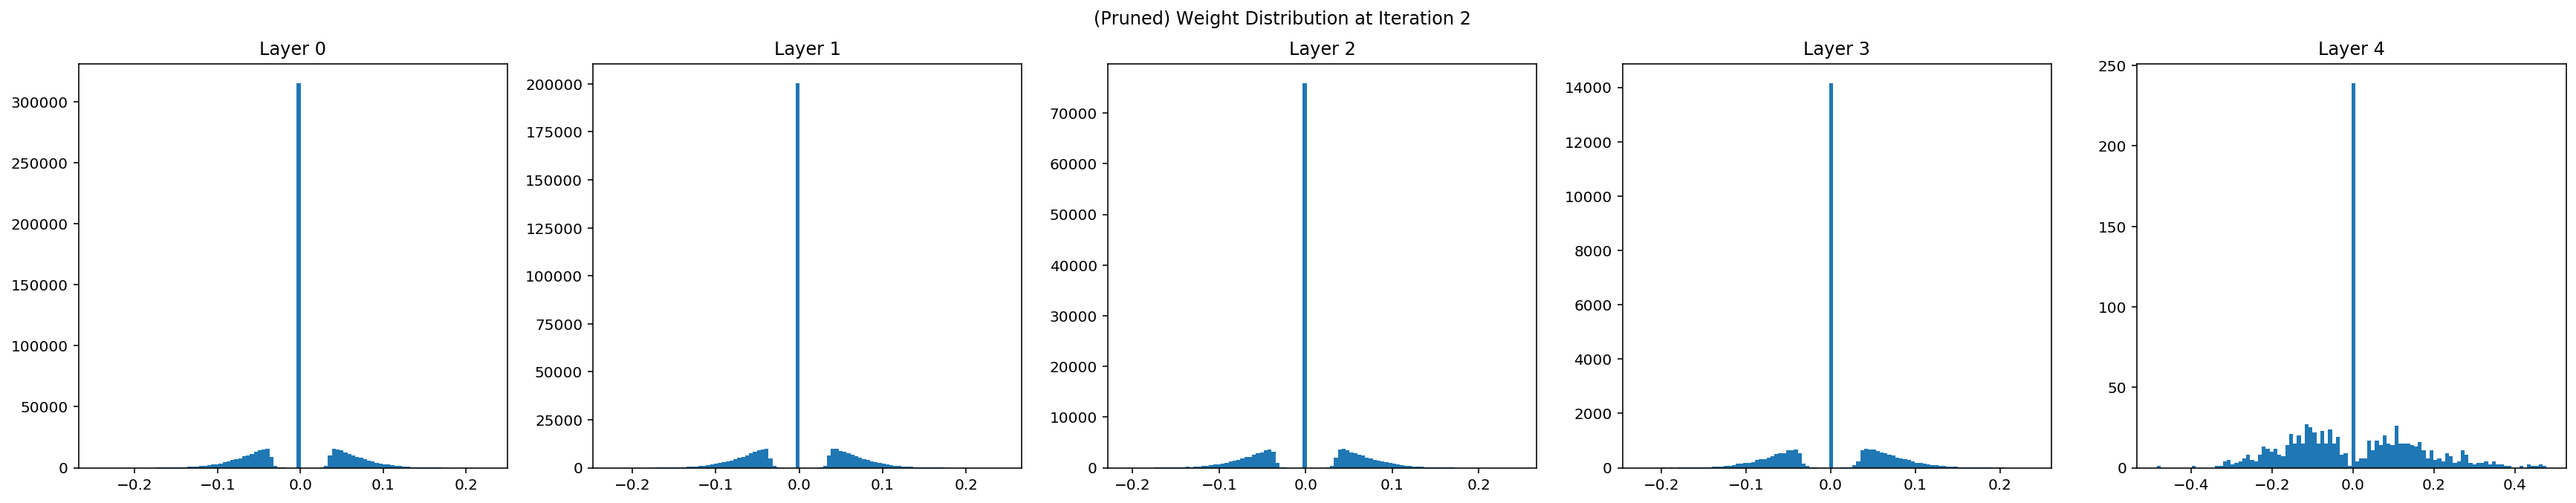

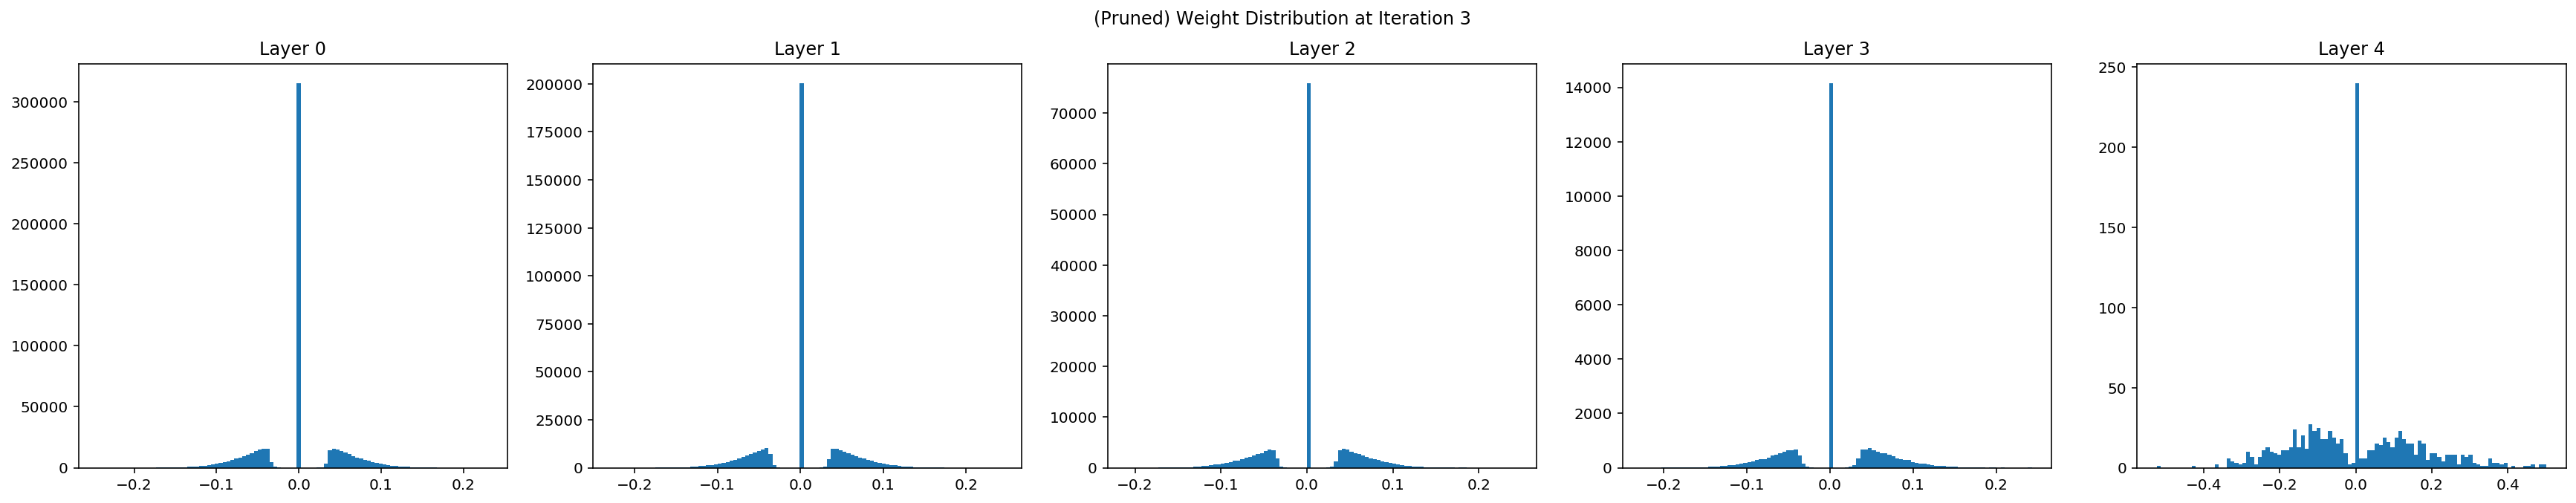

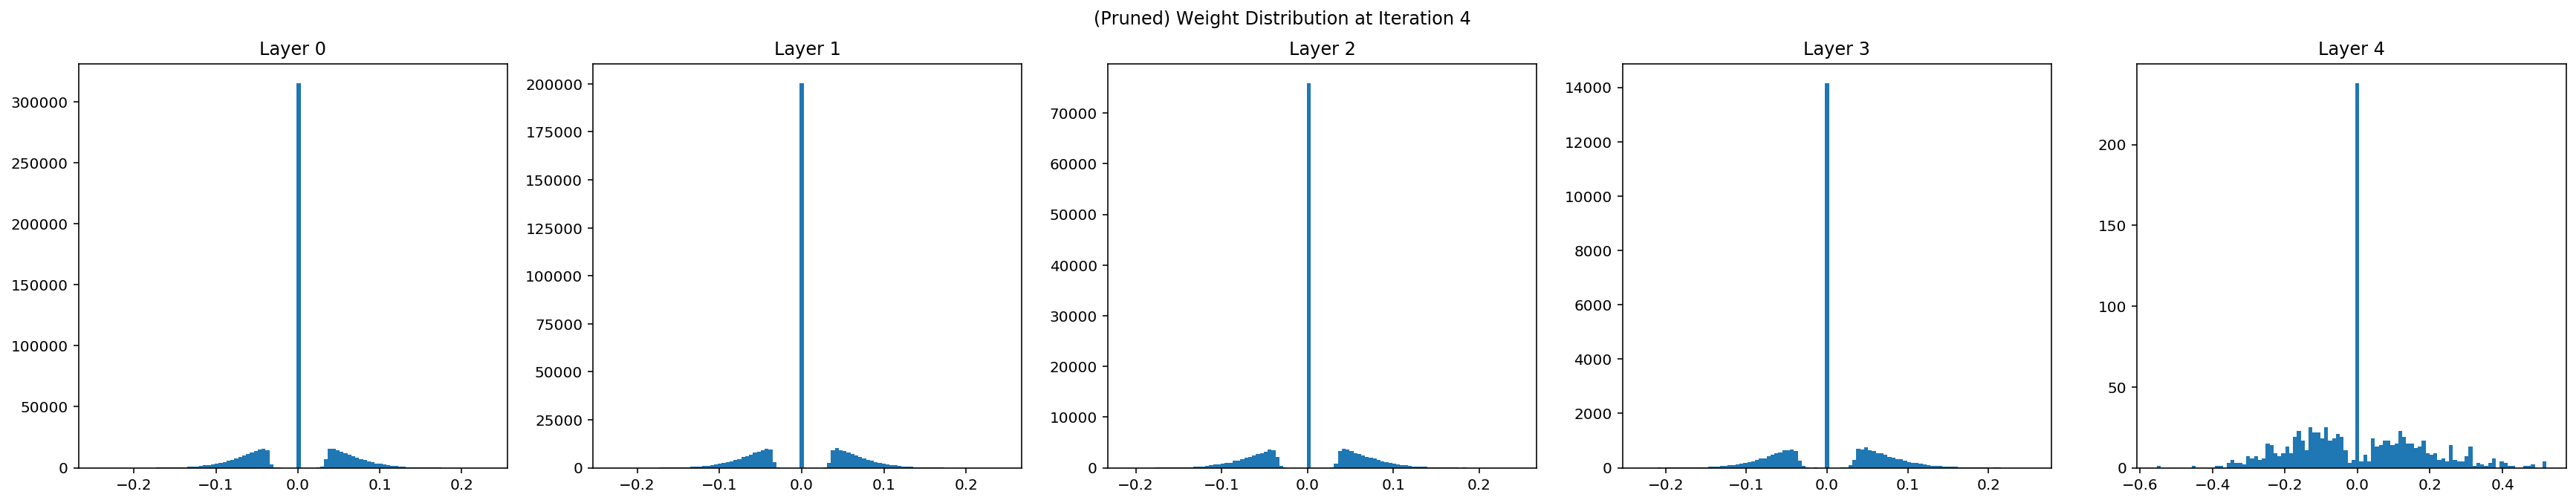

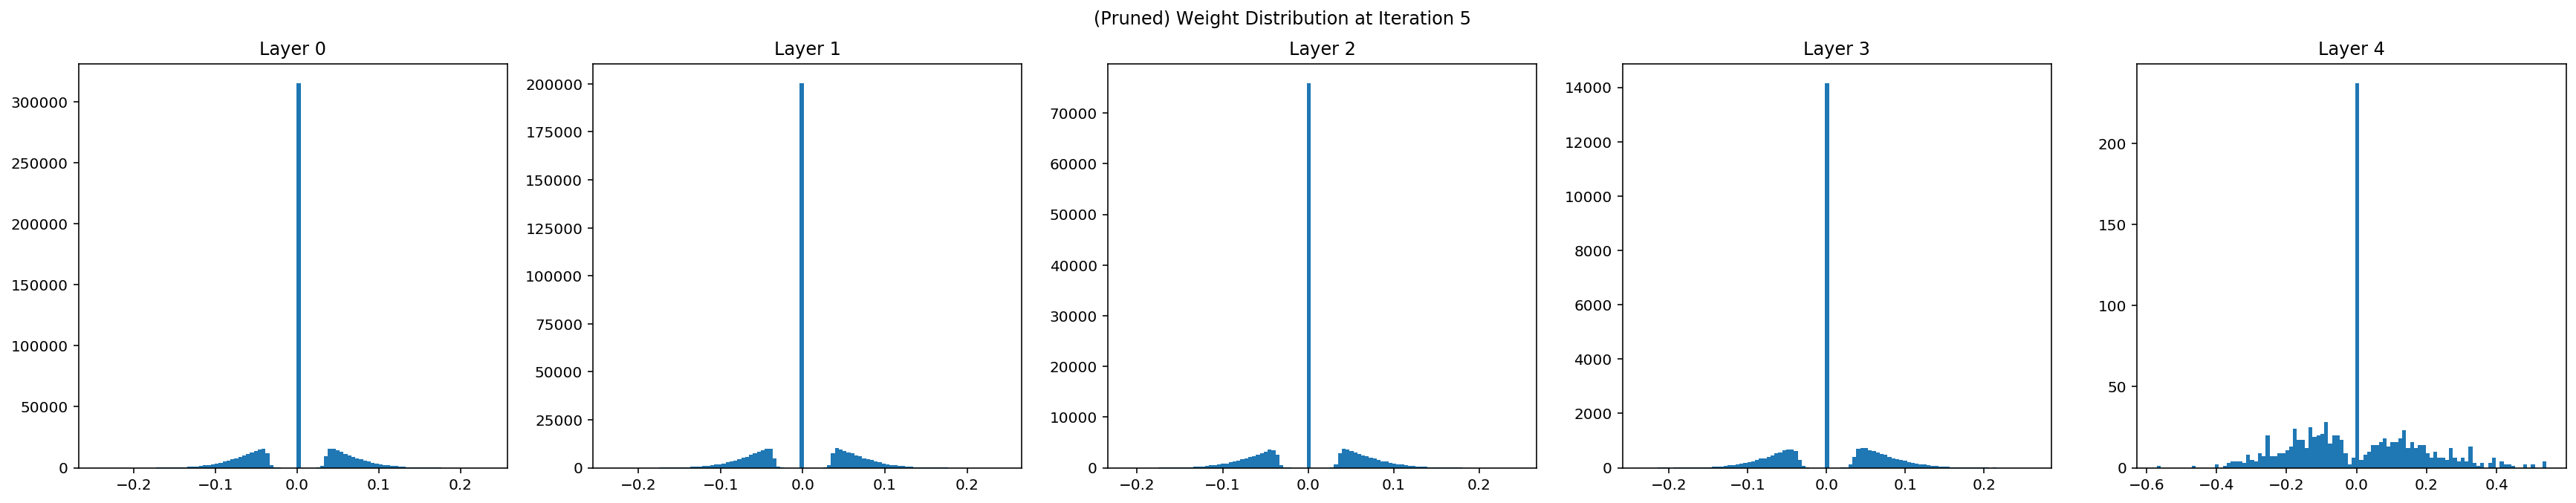

In [160]:
for i,all_weights_iter in enumerate(all_weights_pruned):
    fig = plt.figure(figsize=(30,5))
    if i == 0:
        fig.suptitle("(Pruned) Weight Distribution at Iteration (Re-)Initialization")
    else:
        fig.suptitle(f"(Pruned) Weight Distribution at Iteration {i}")
    for j,all_weights_layer in enumerate (all_weights_iter):
        plt.subplot(1,5,j+1)
        plt.title(f"Layer {j}")
        _ = plt.hist(all_weights_layer.flatten(), bins=100)

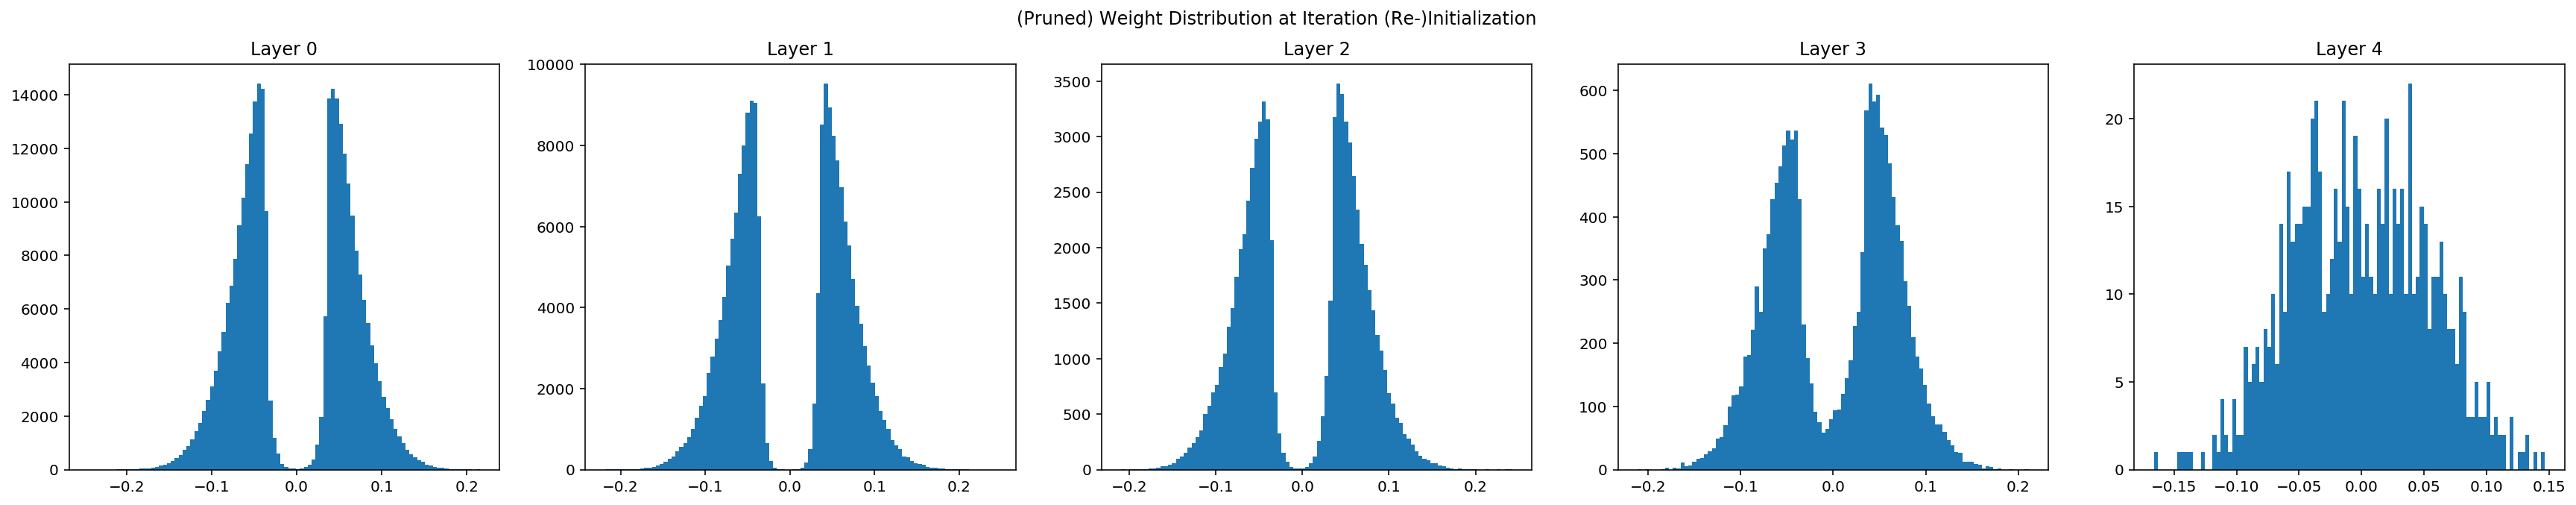

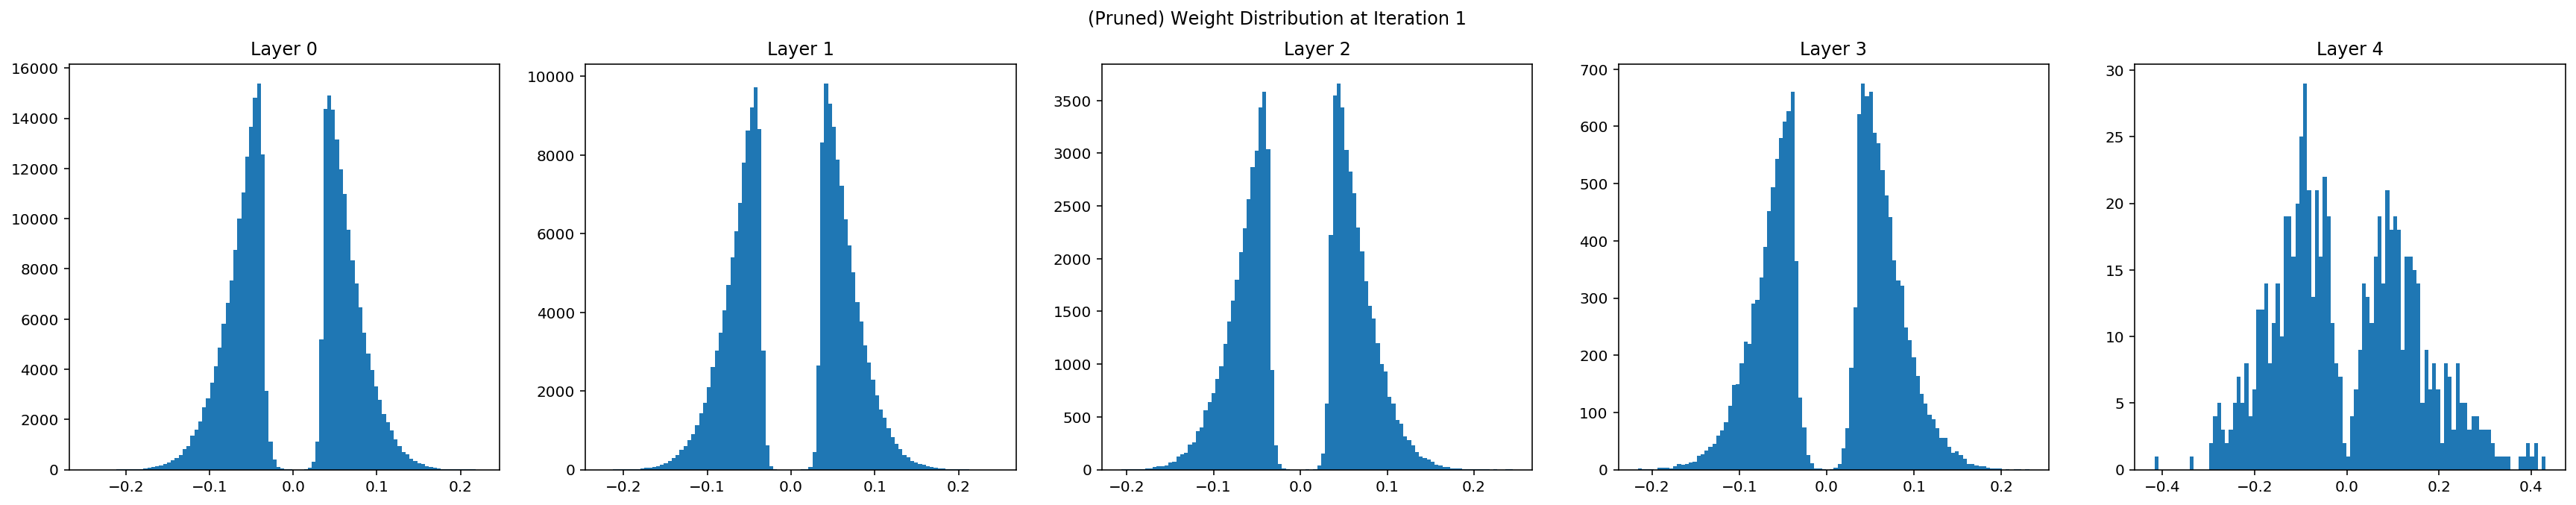

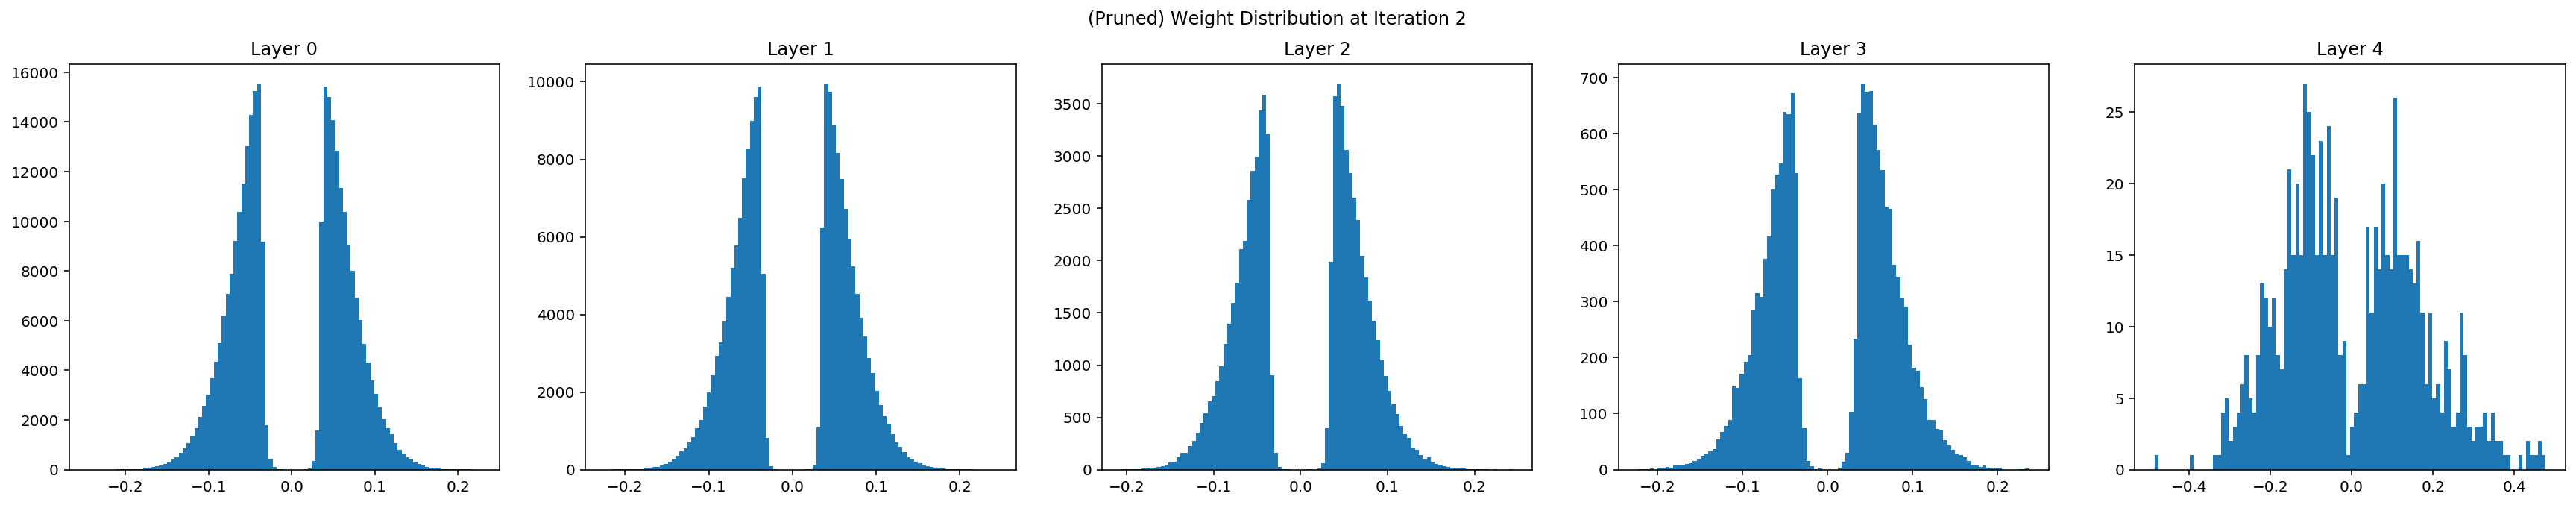

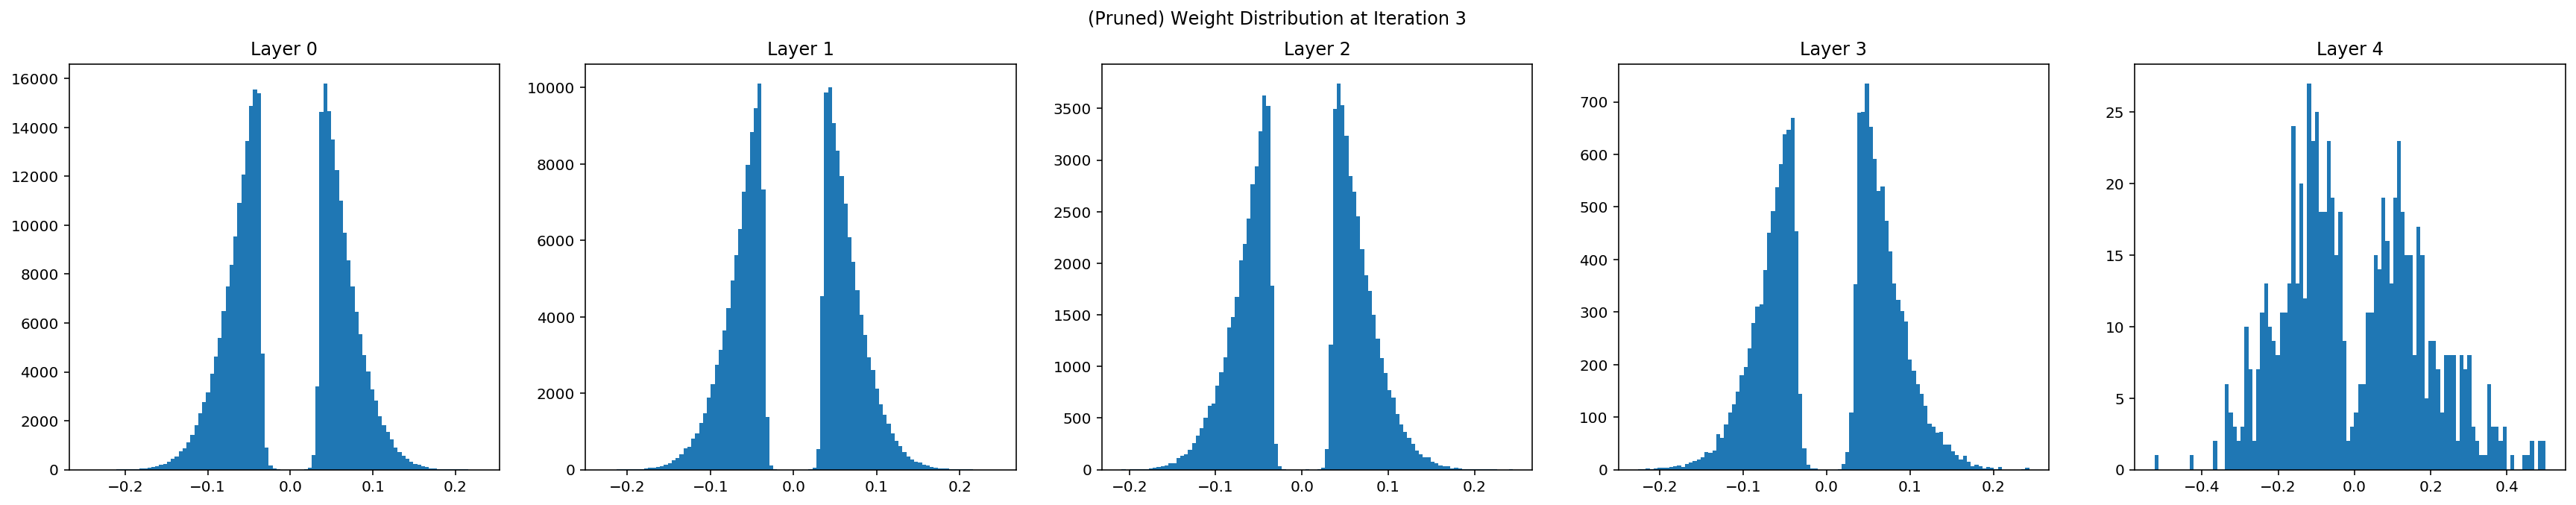

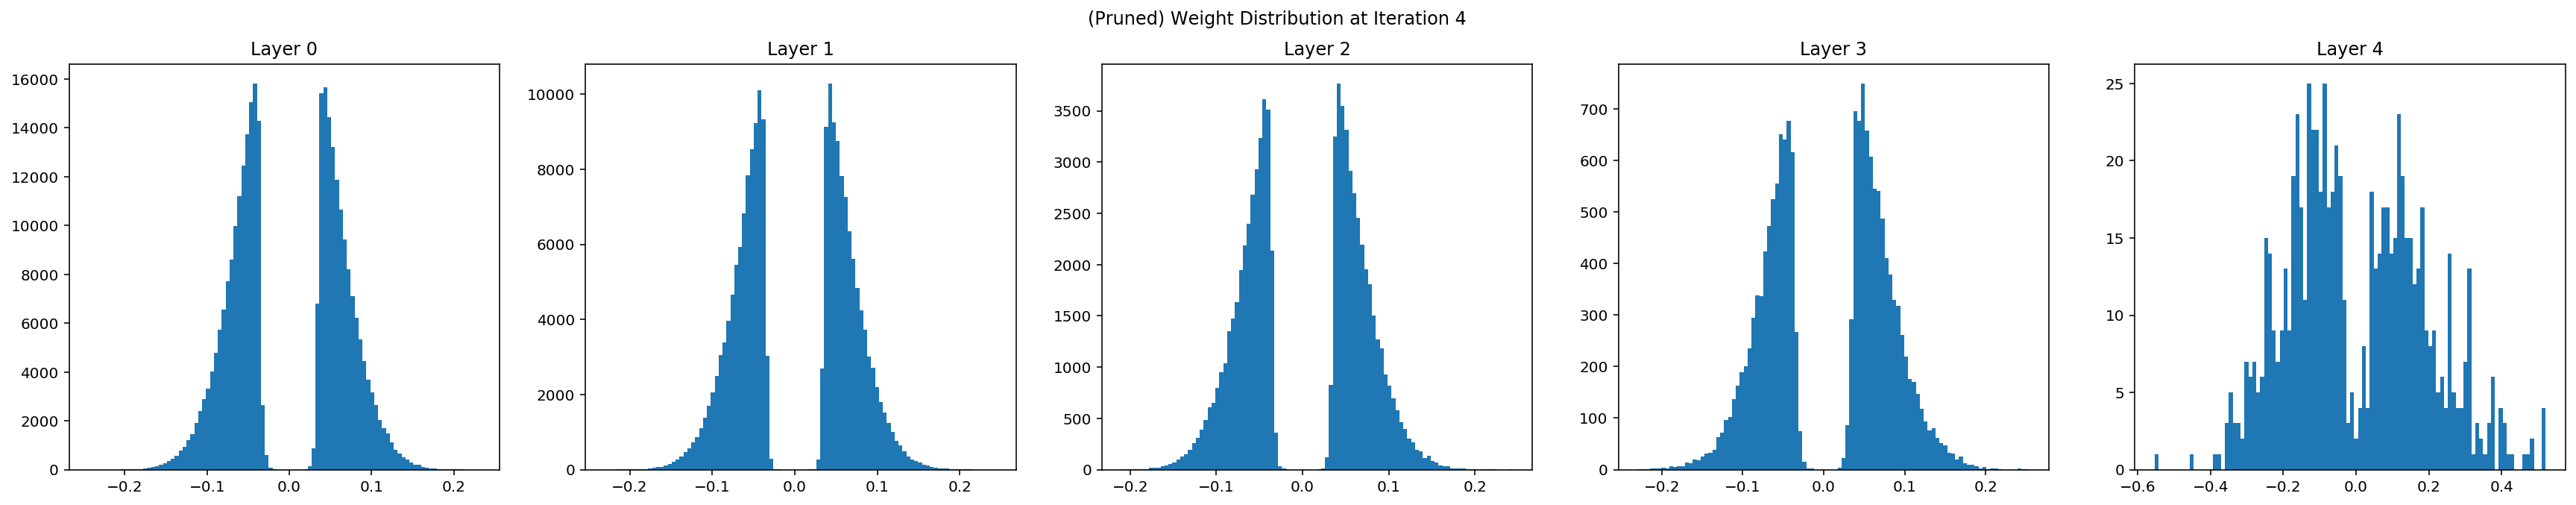

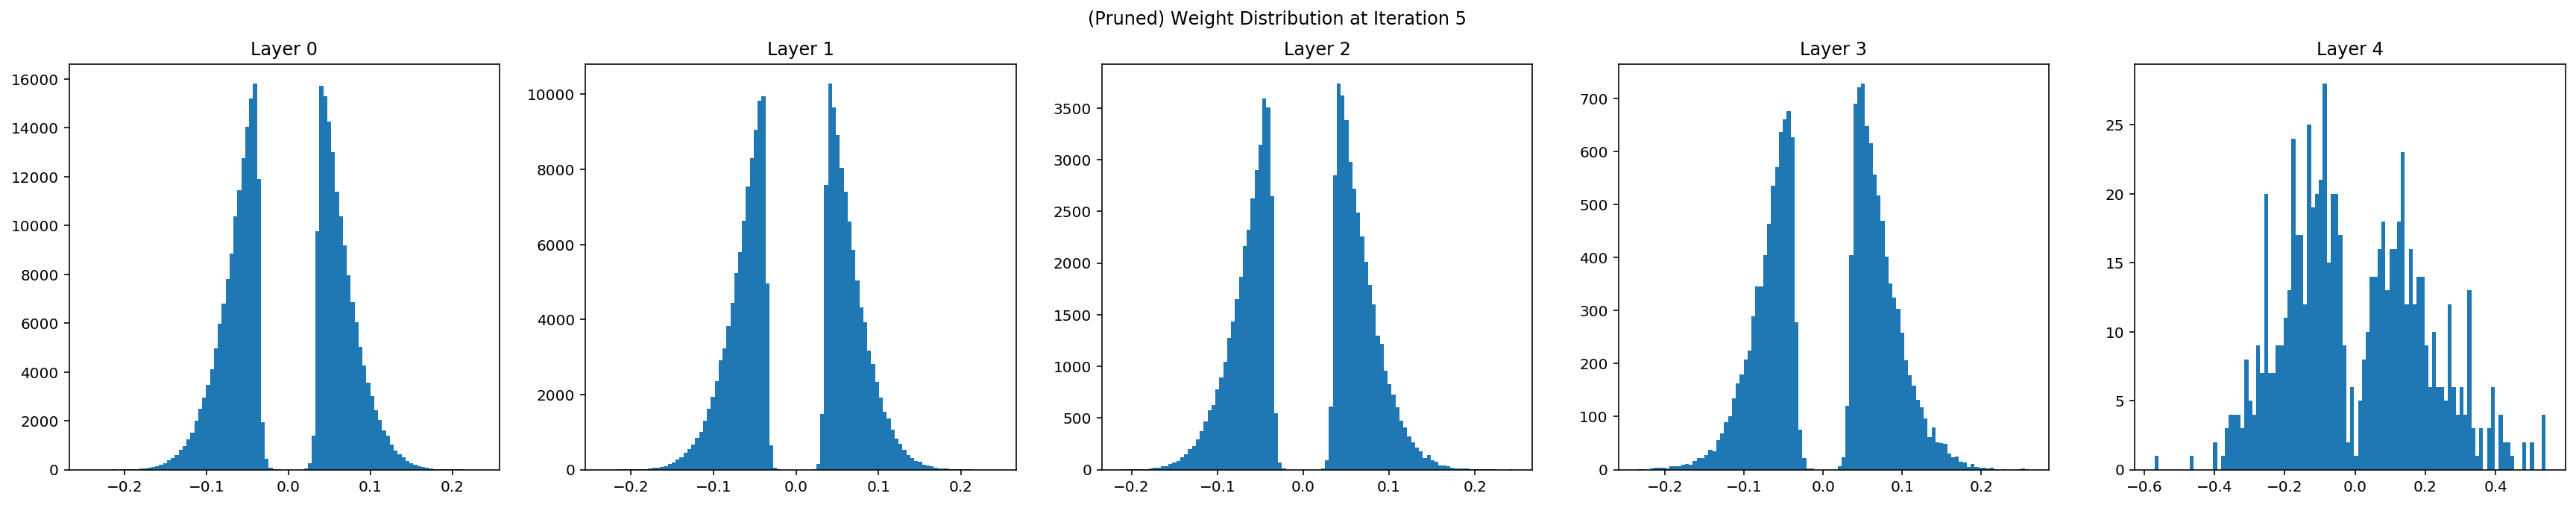

In [161]:
for i,all_weights_iter in enumerate(all_weights_nonzero):
    fig = plt.figure(figsize=(30,5))
    if i == 0:
        fig.suptitle("(Pruned) Weight Distribution at Iteration (Re-)Initialization")
    else:
        fig.suptitle(f"(Pruned) Weight Distribution at Iteration {i}")
    for j,all_weights_layer in enumerate (all_weights_iter):
        plt.subplot(1,5,j+1)
        plt.title(f"Layer {j}")
        _ = plt.hist(all_weights_layer.flatten(), bins=100)

In [162]:
delta_to_prior_layer = []
for i in range(1,epochs+1):
    tmp_epoch = []
    for t1, t0 in zip(all_weights[i], all_weights[i-1]):
        tmp_epoch.append(t1-t0)
    delta_to_prior_layer.append(tmp_epoch)

In [163]:
delta_to_prior_layer_pruned = []
for i in range(1,epochs+1):
    tmp_epoch = []
    for t1, t0 in zip(all_weights_pruned[i], all_weights_pruned[i-1]):
        tmp_epoch.append(t1-t0)
    delta_to_prior_layer_pruned.append(tmp_epoch)

In [164]:
delta_to_prior_layer_nonzero = []
for i in range(1,epochs+1):
    tmp_epoch = []
    for t1, t0 in zip(all_weights_nonzero[i], all_weights_nonzero[i-1]):
        tmp_epoch.append(t1-t0)
    delta_to_prior_layer_nonzero.append(tmp_epoch)

In [165]:
len(delta_to_prior_layer)

5

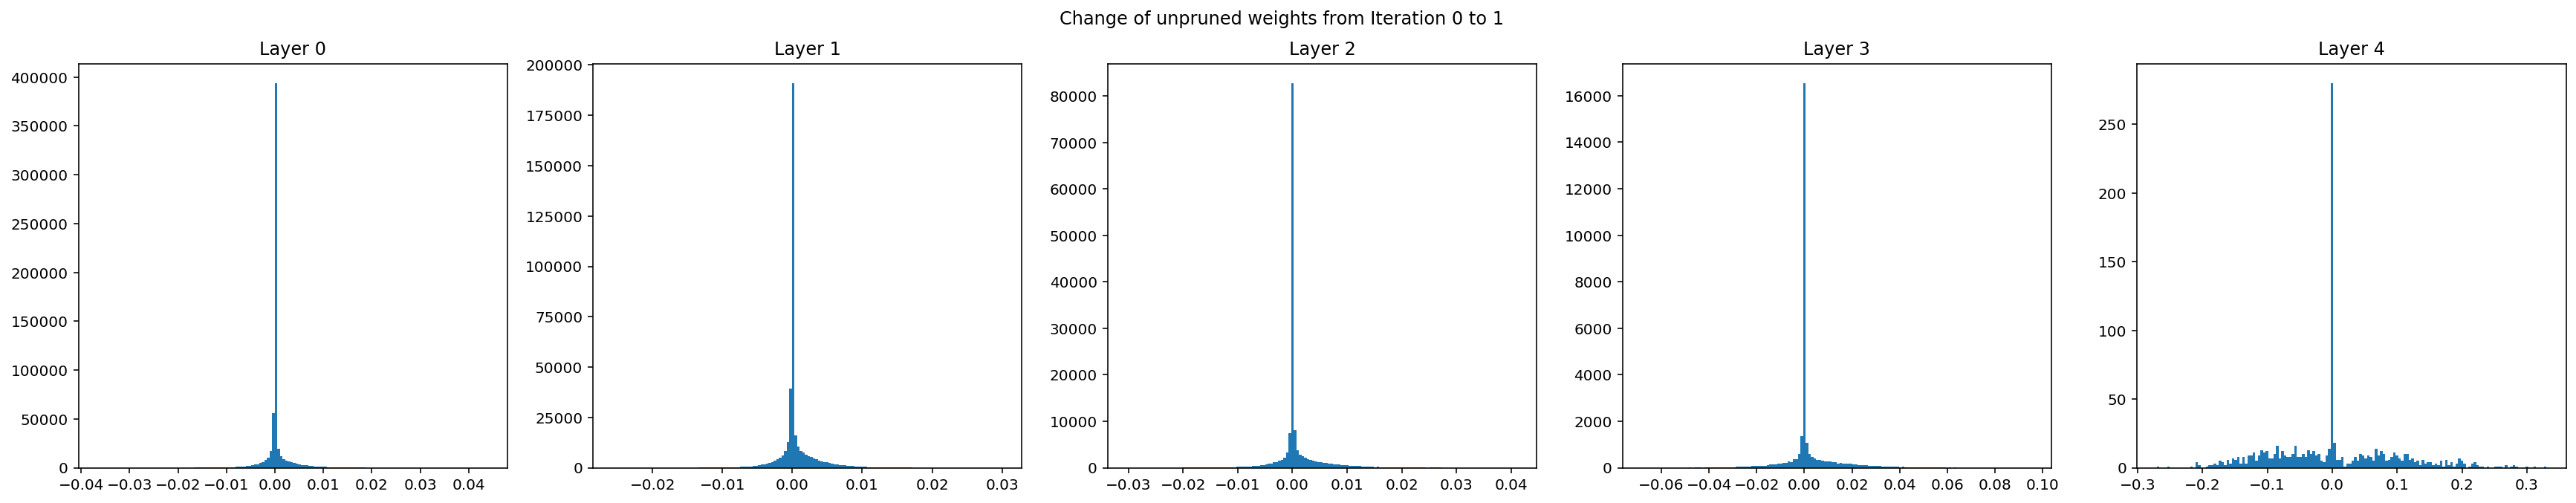

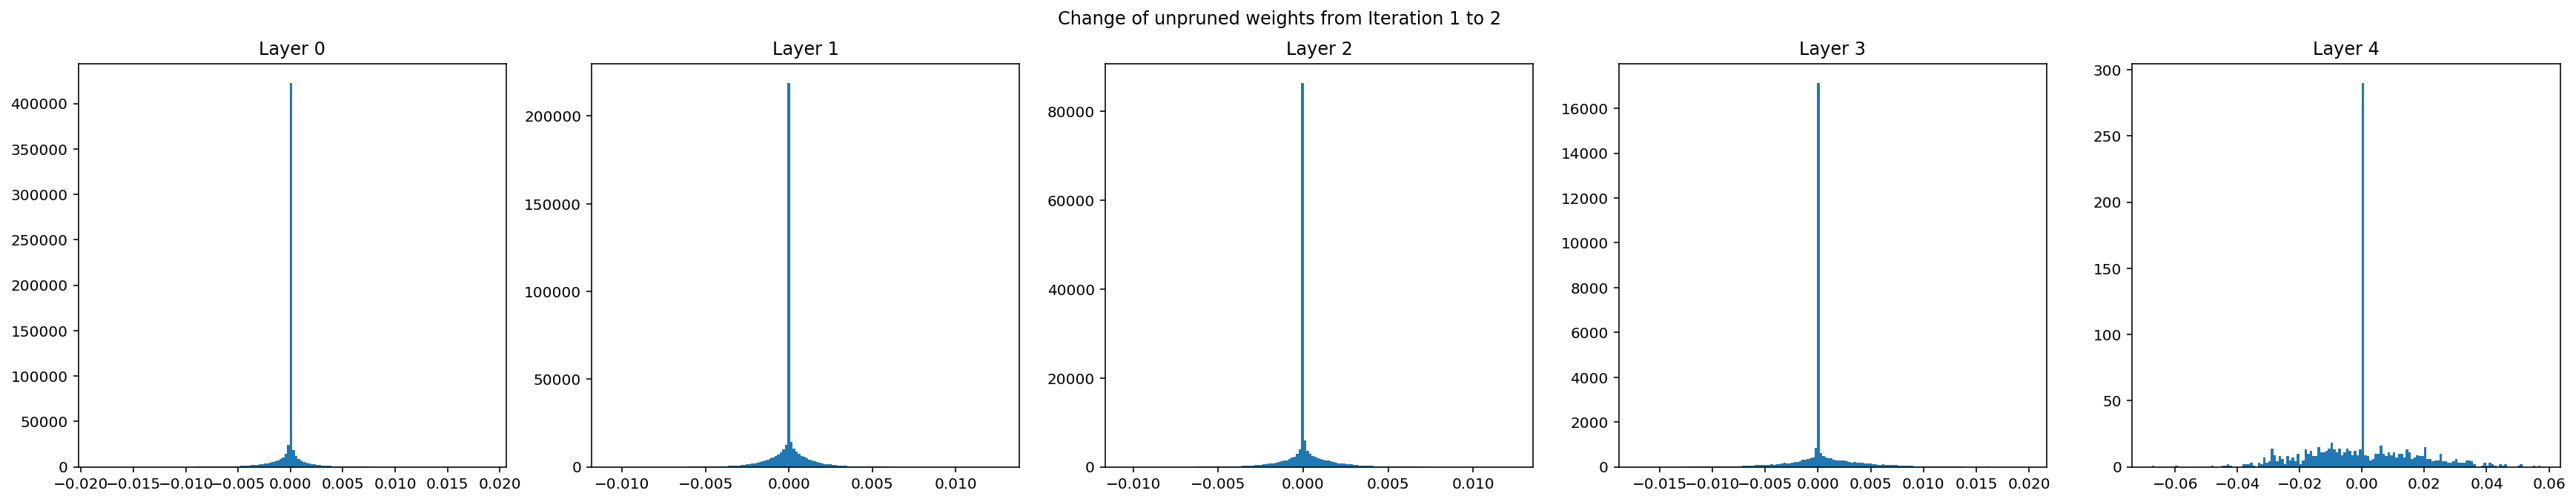

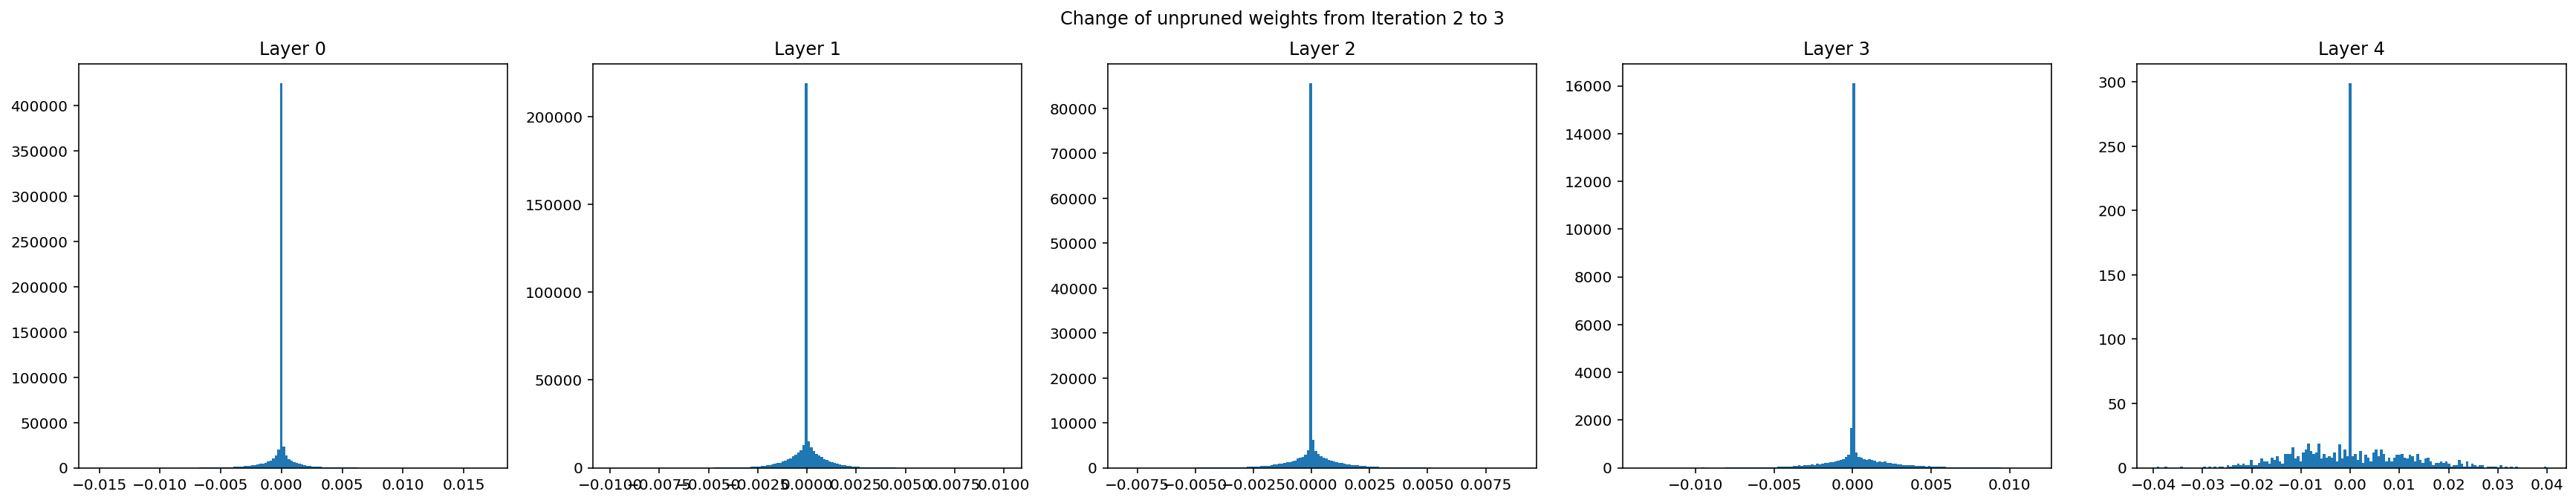

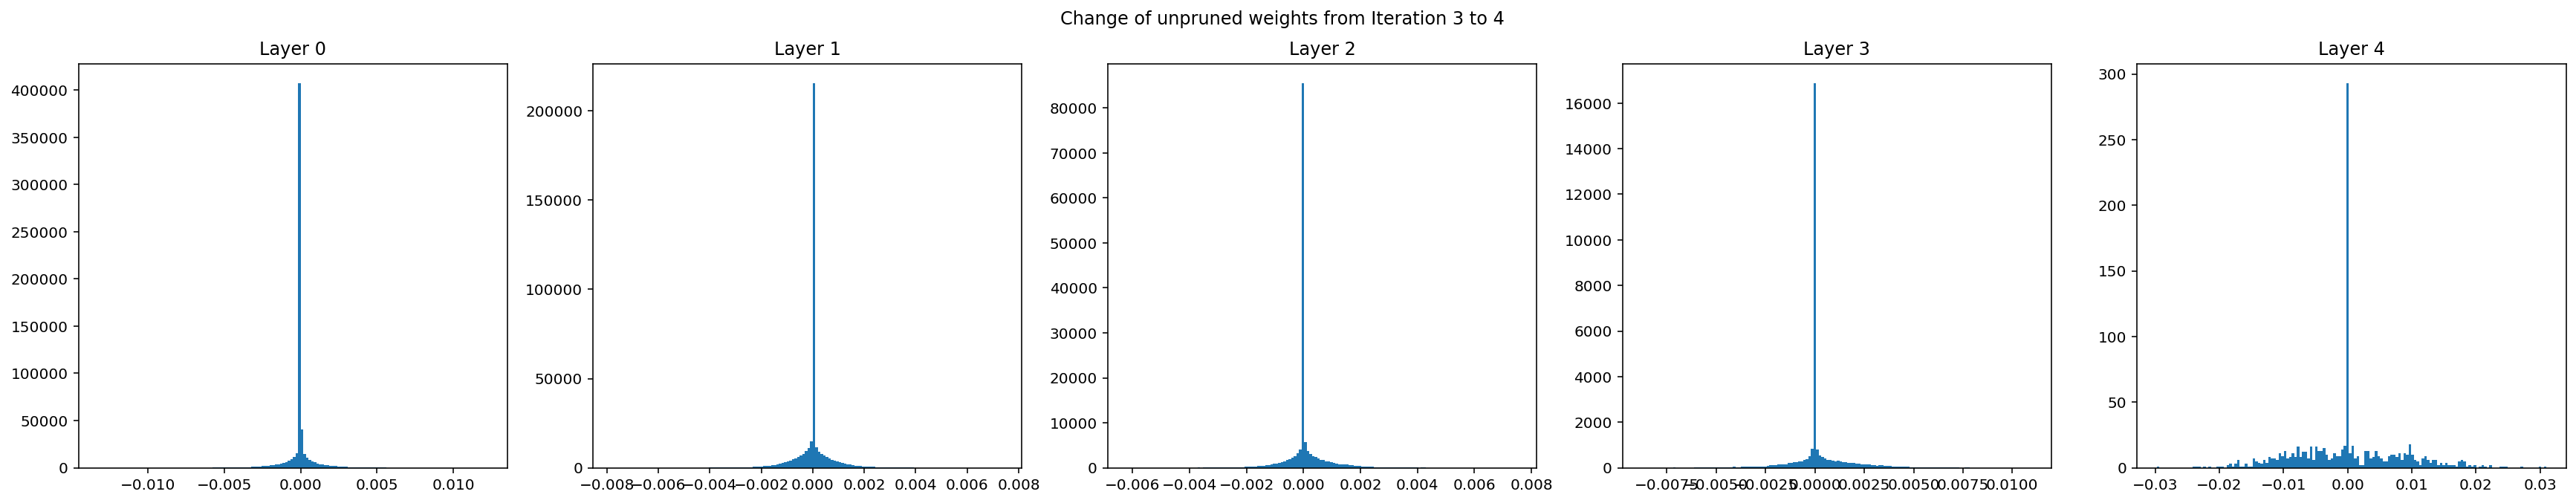

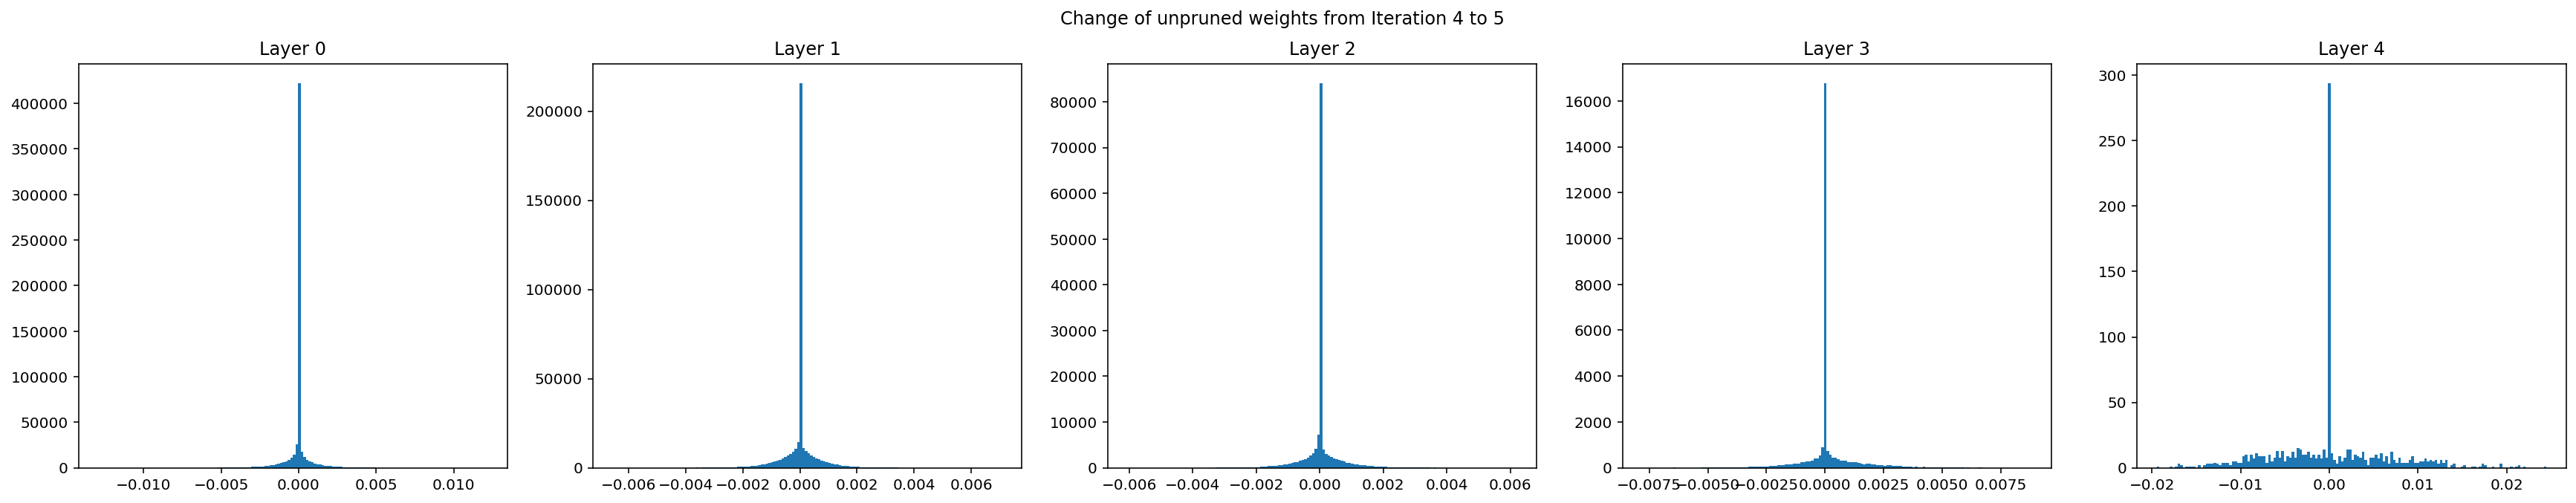

In [166]:
for i,all_weights_iter in enumerate(delta_to_prior_layer):
    fig = plt.figure(figsize=(30,5))
    fig.suptitle(f"Change of unpruned weights from Iteration {i} to {i+1}")
    for j,all_weights_layer in enumerate (all_weights_iter):
        plt.subplot(1,5,j+1)
        plt.title(f"Layer {j}")
        _ = plt.hist(all_weights_layer.flatten(), bins=150)

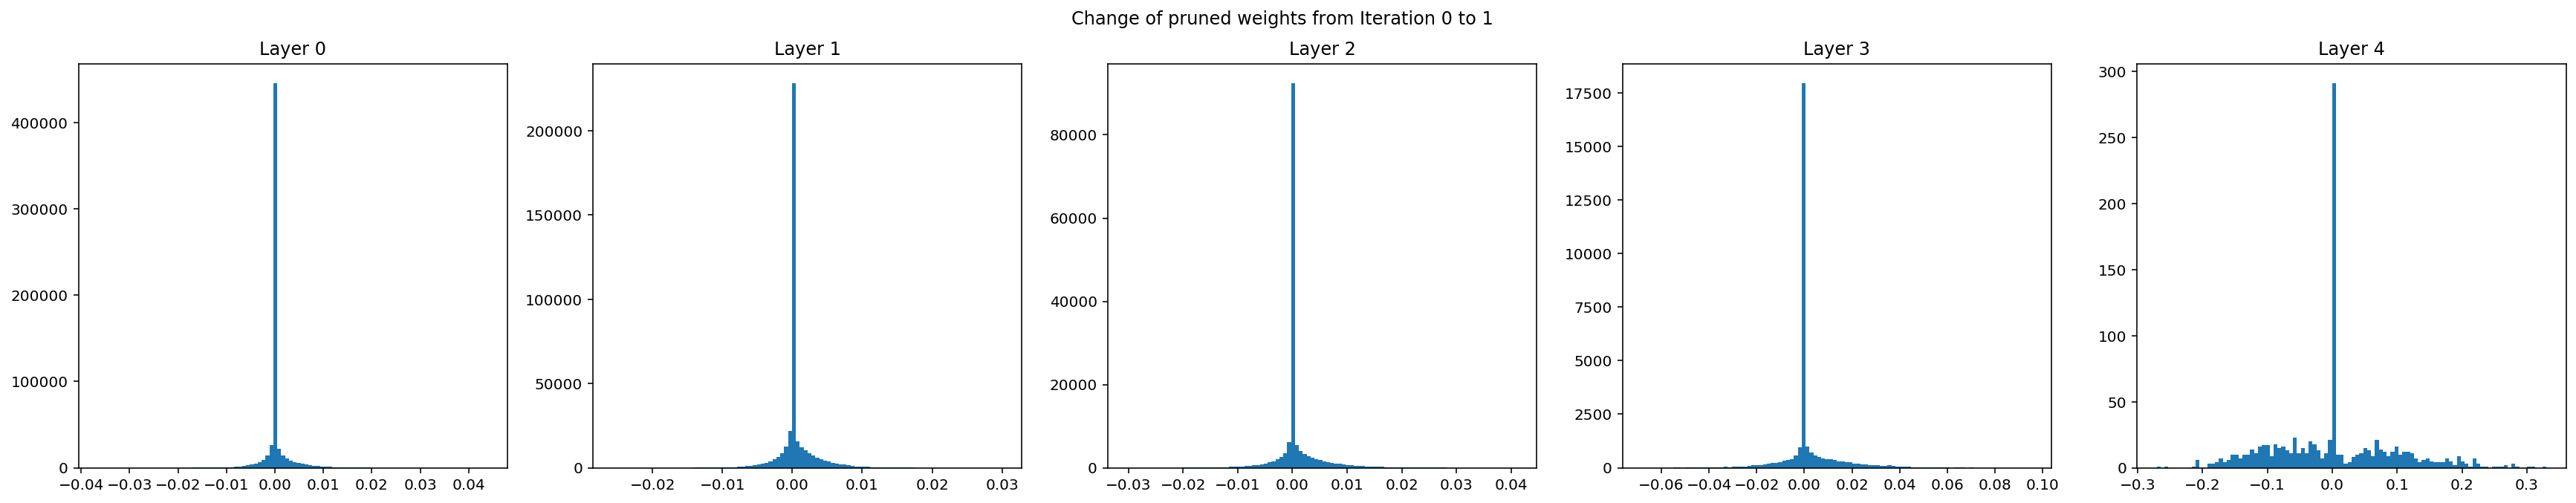

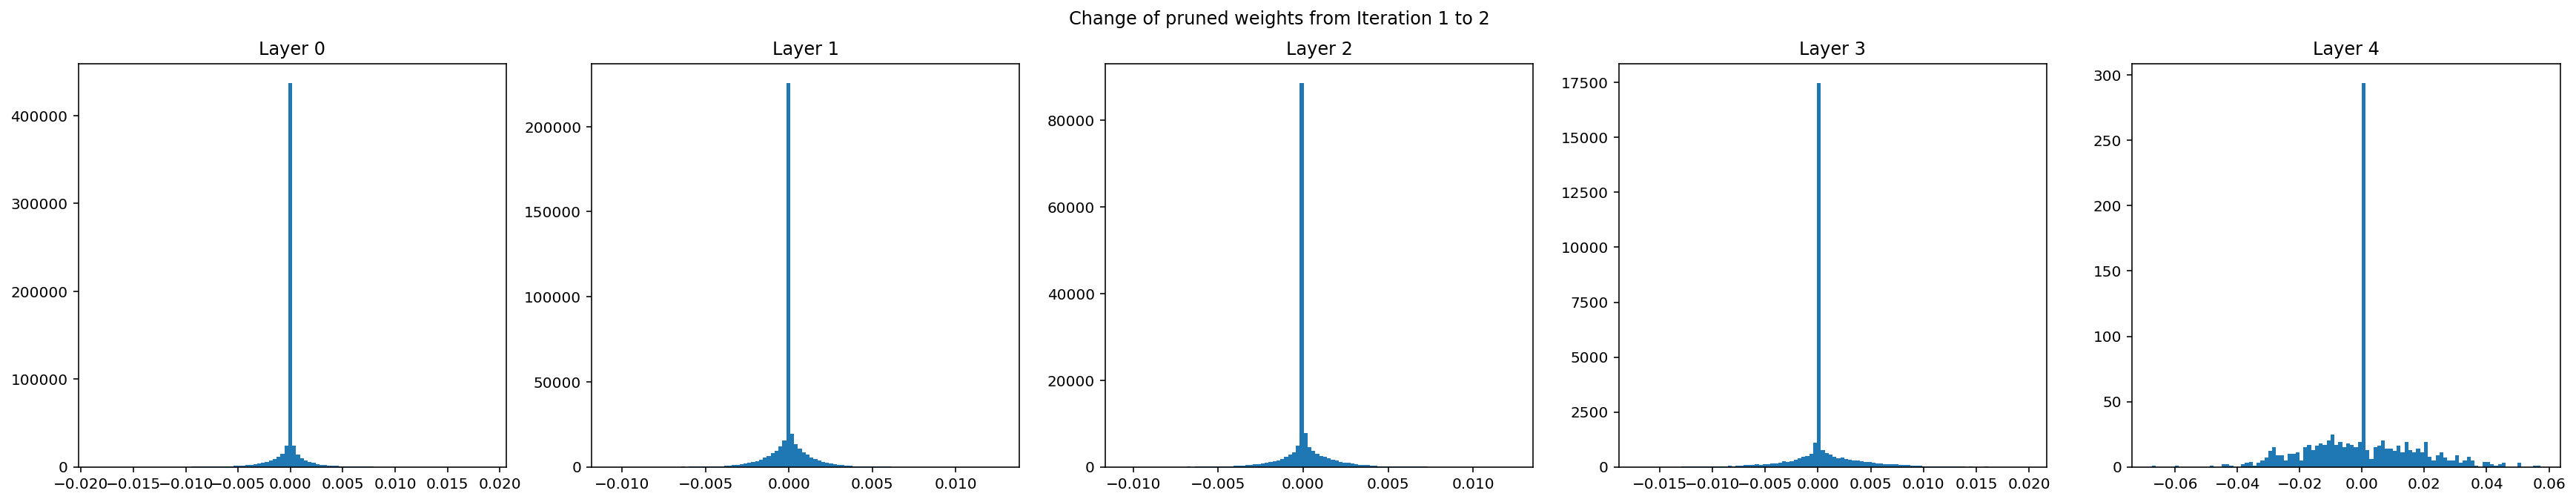

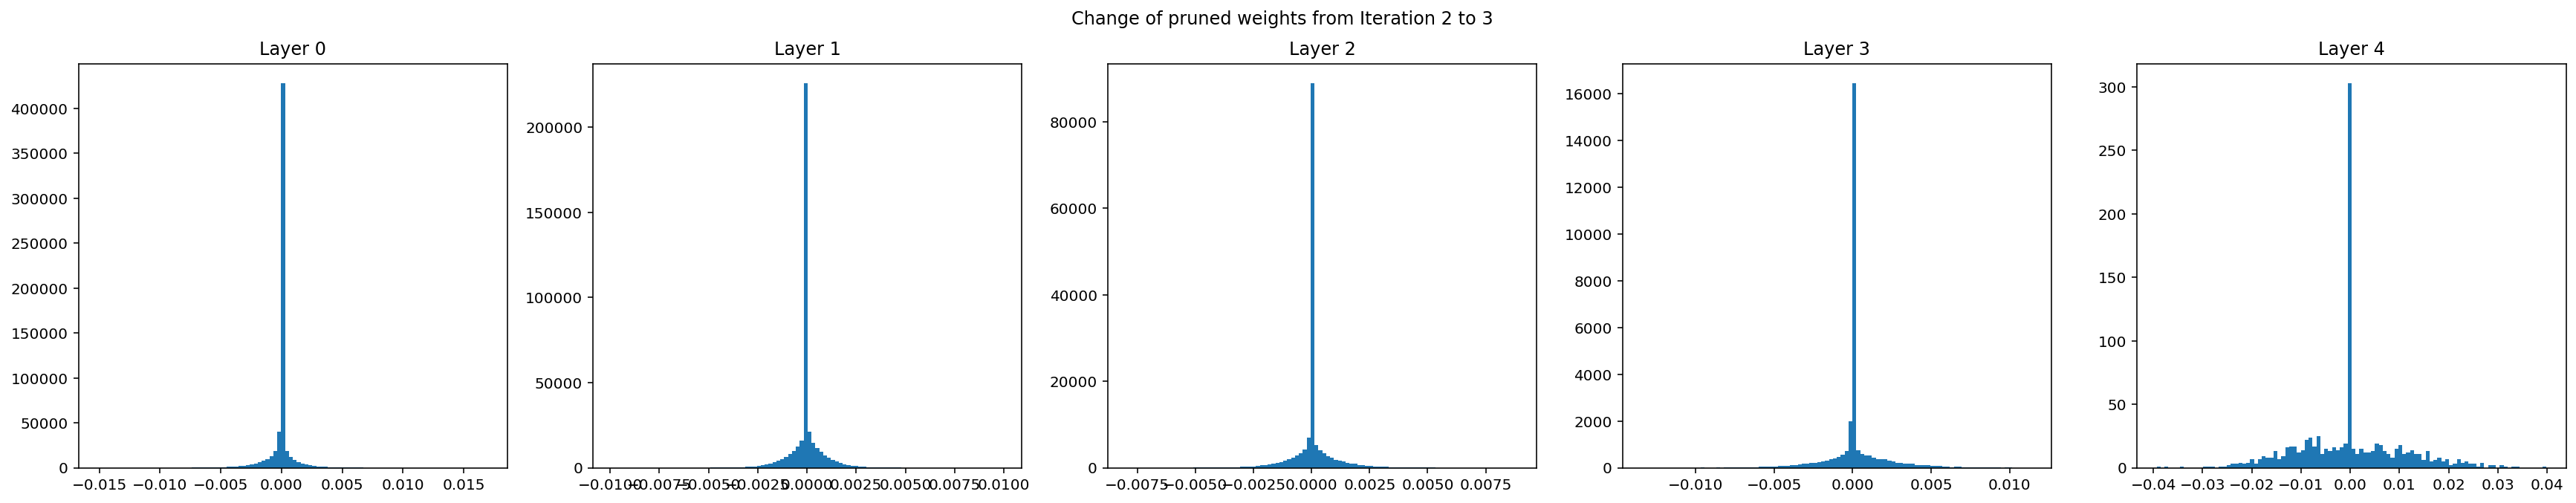

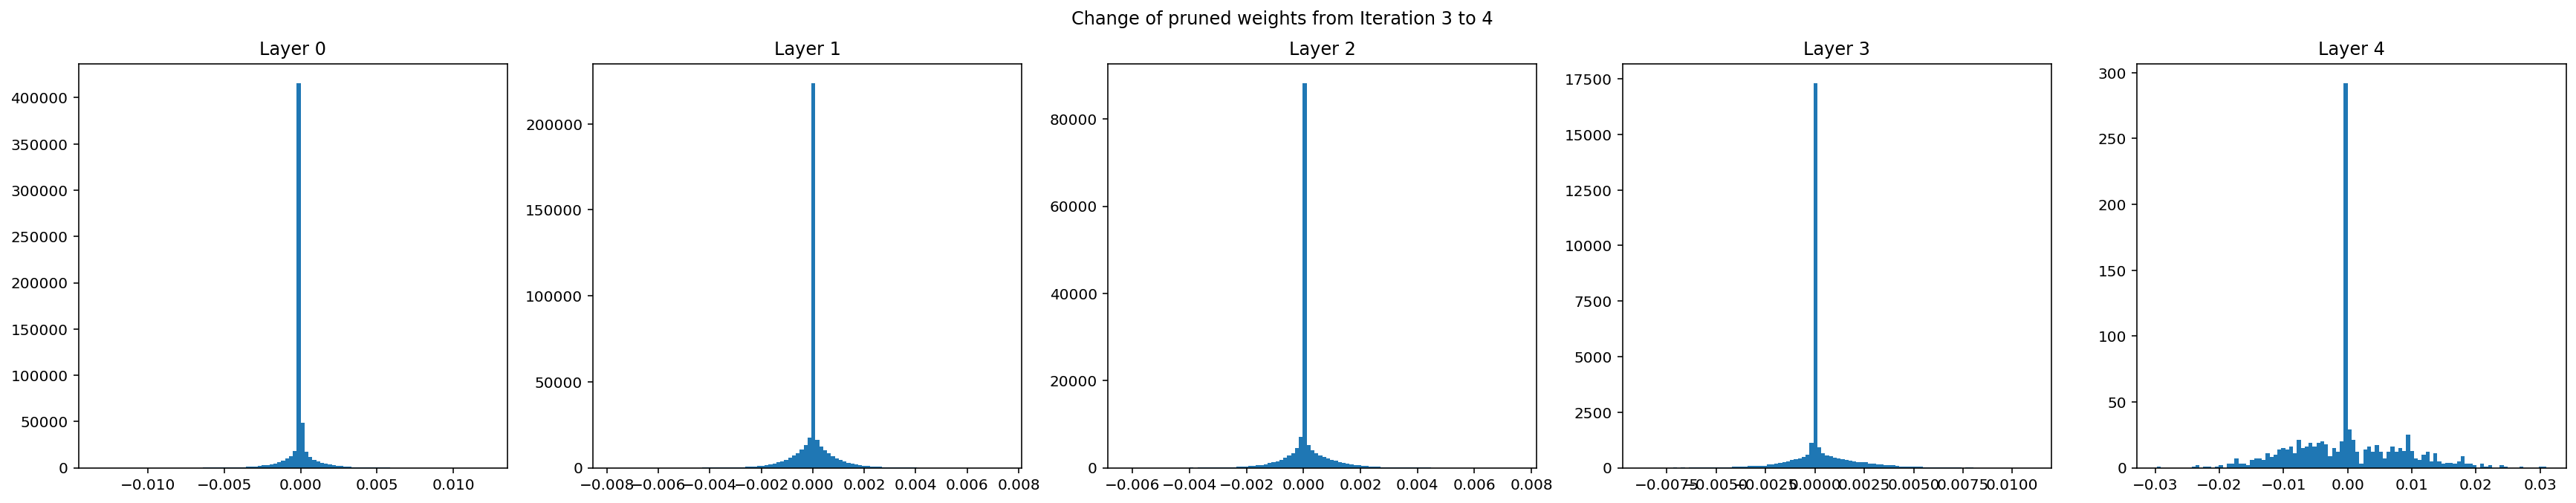

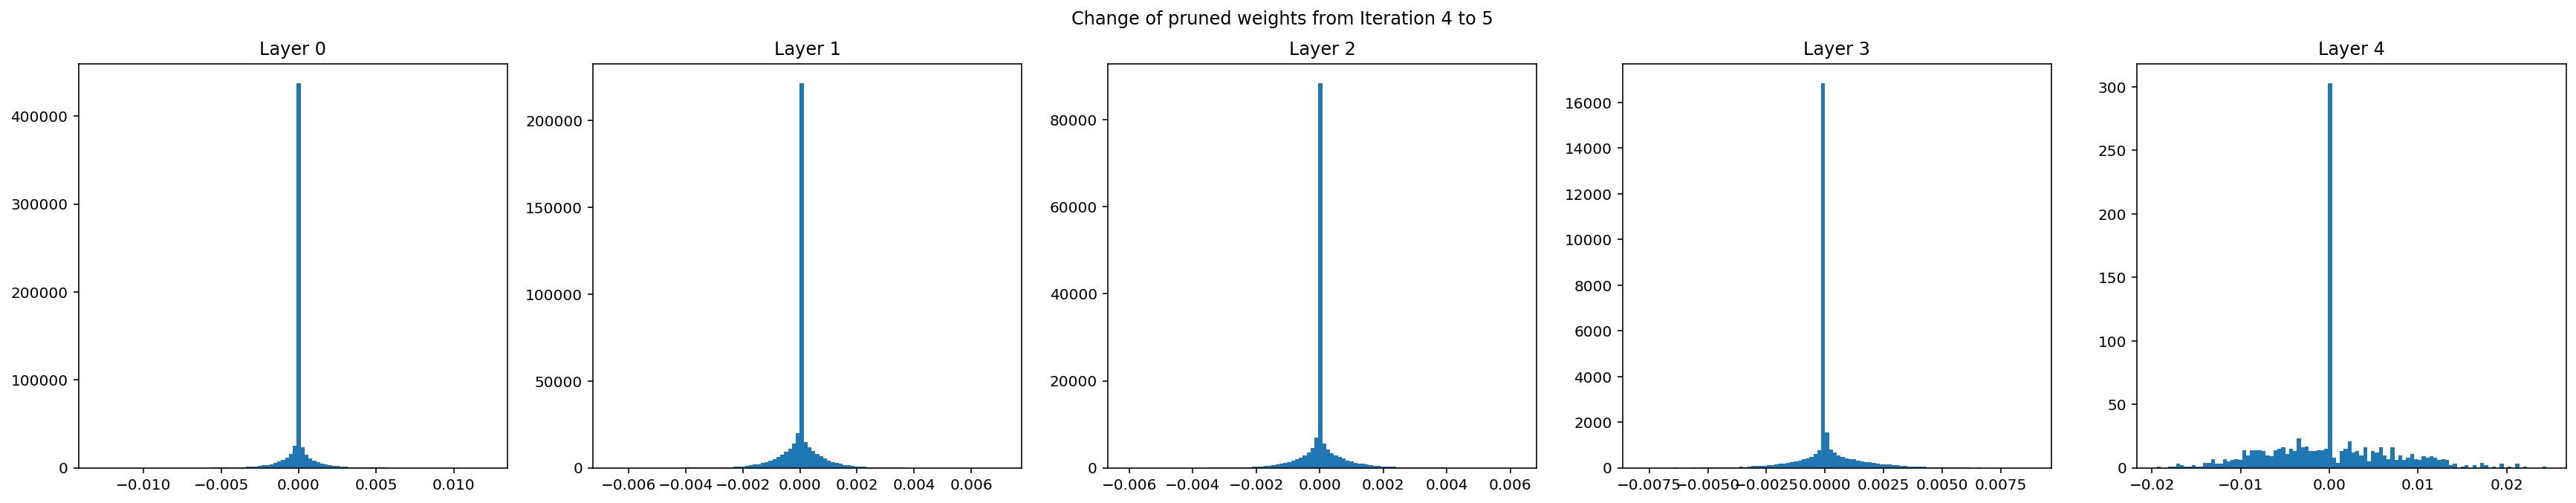

In [167]:
for i,all_weights_iter in enumerate(delta_to_prior_layer_pruned):
    fig = plt.figure(figsize=(30,5))
    fig.suptitle(f"Change of pruned weights from Iteration {i} to {i+1}")
    for j,all_weights_layer in enumerate (all_weights_iter):
        plt.subplot(1,5,j+1)
        plt.title(f"Layer {j}")
        _ = plt.hist(all_weights_layer.flatten(), bins=100)

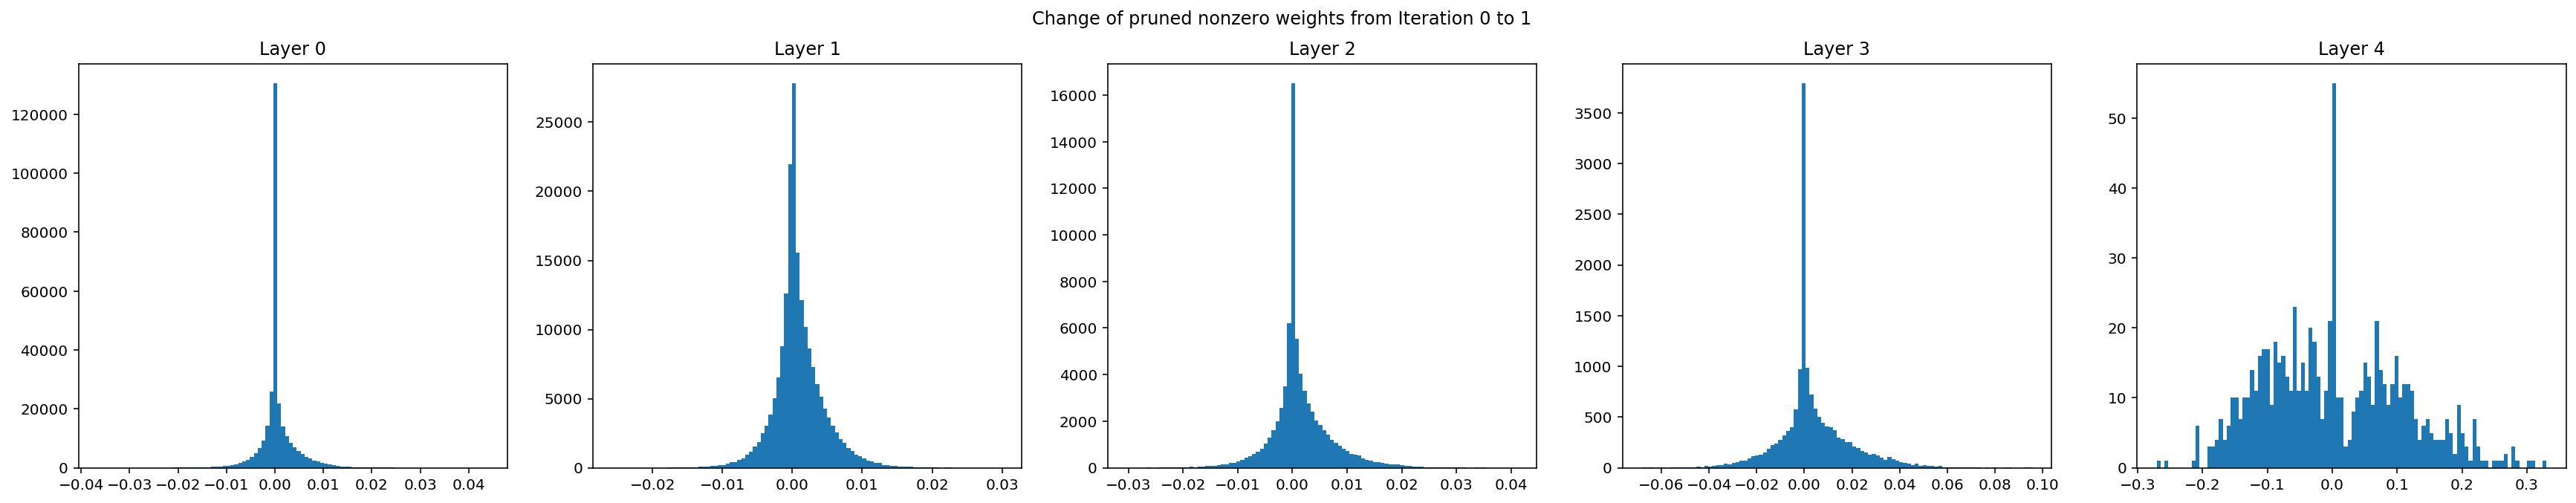

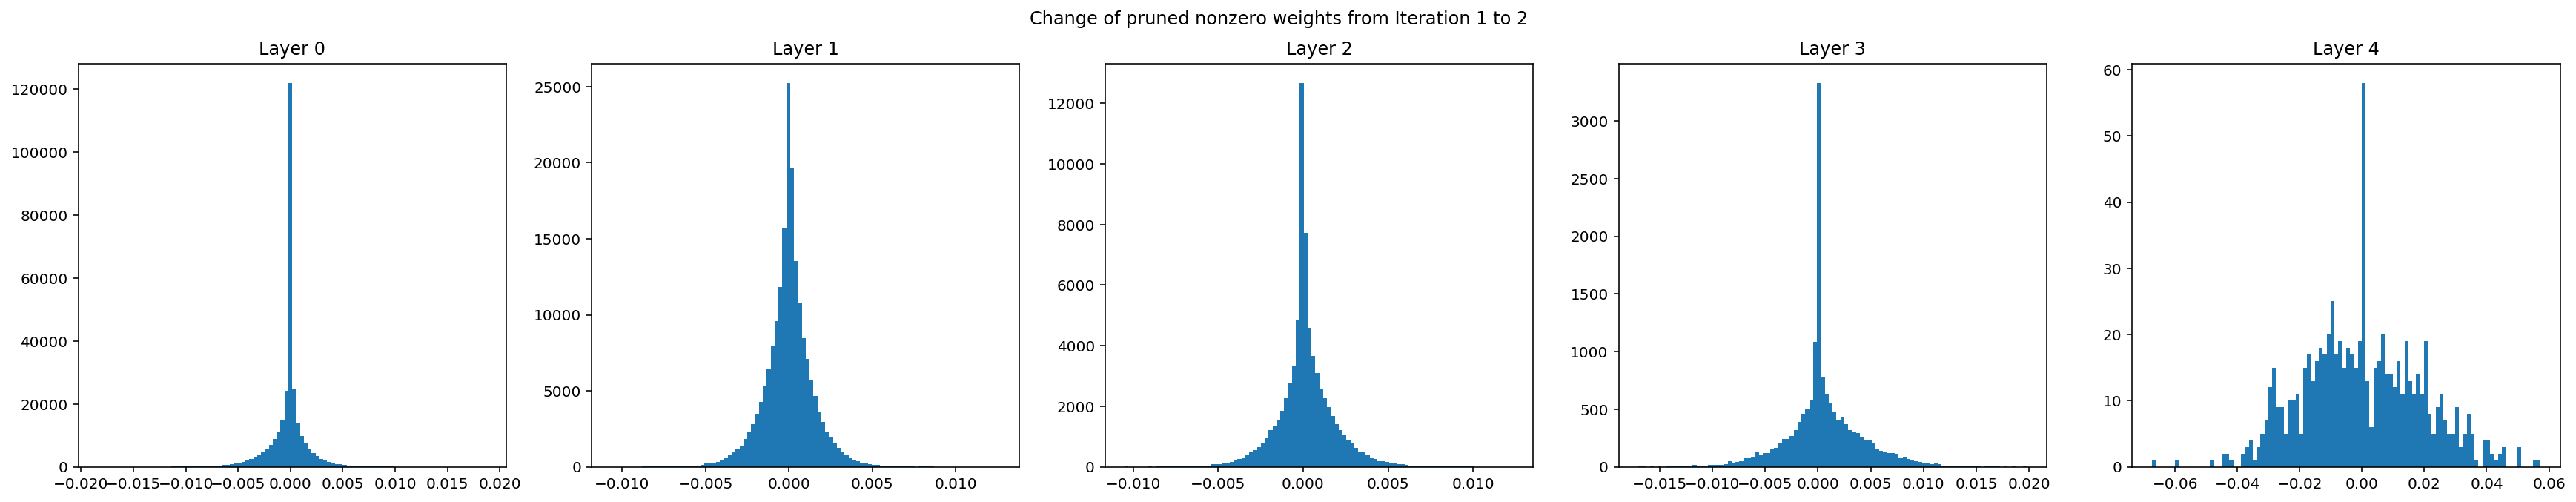

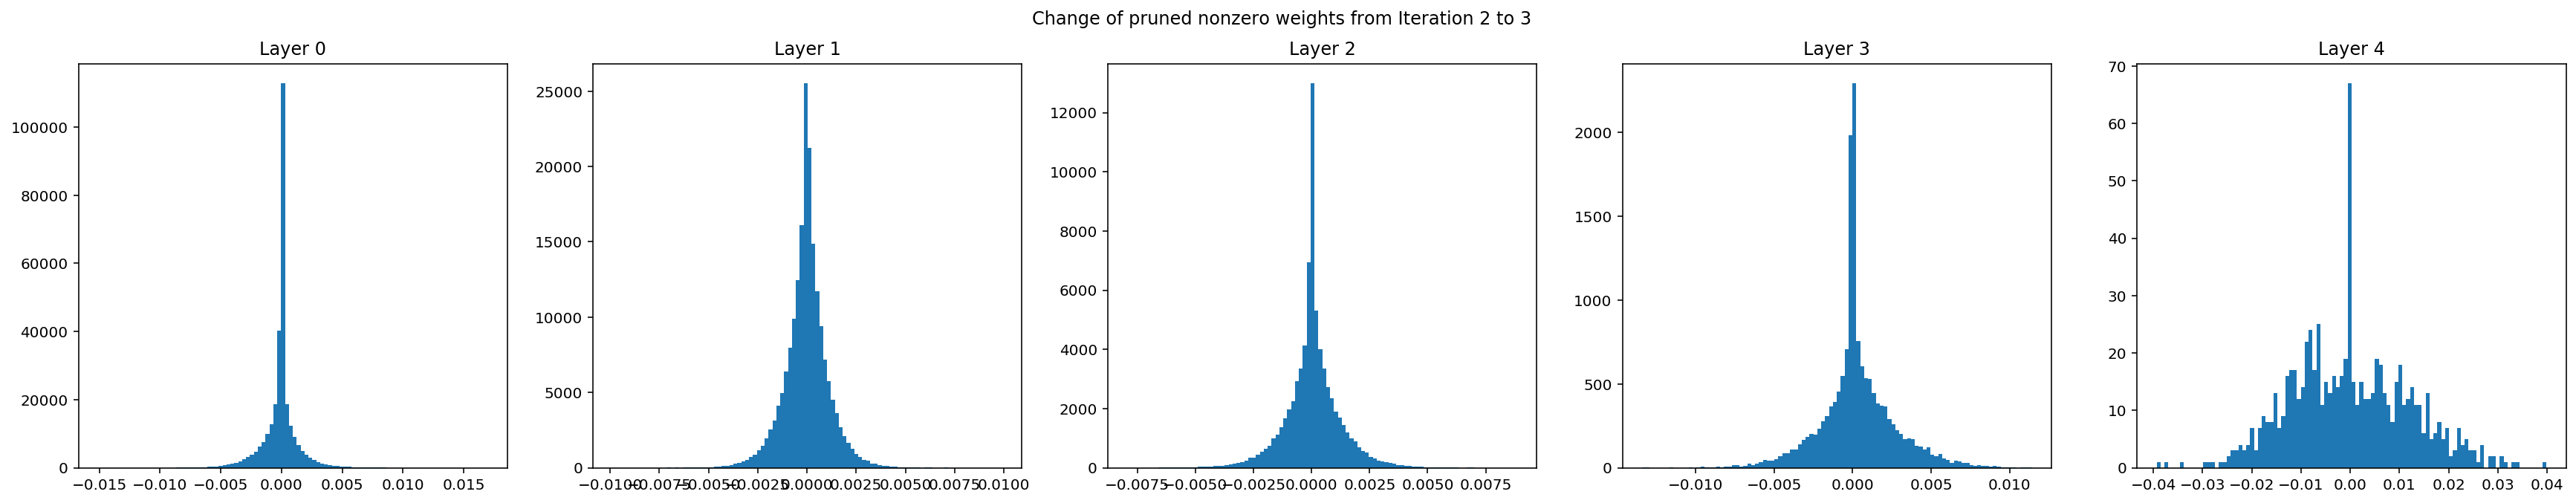

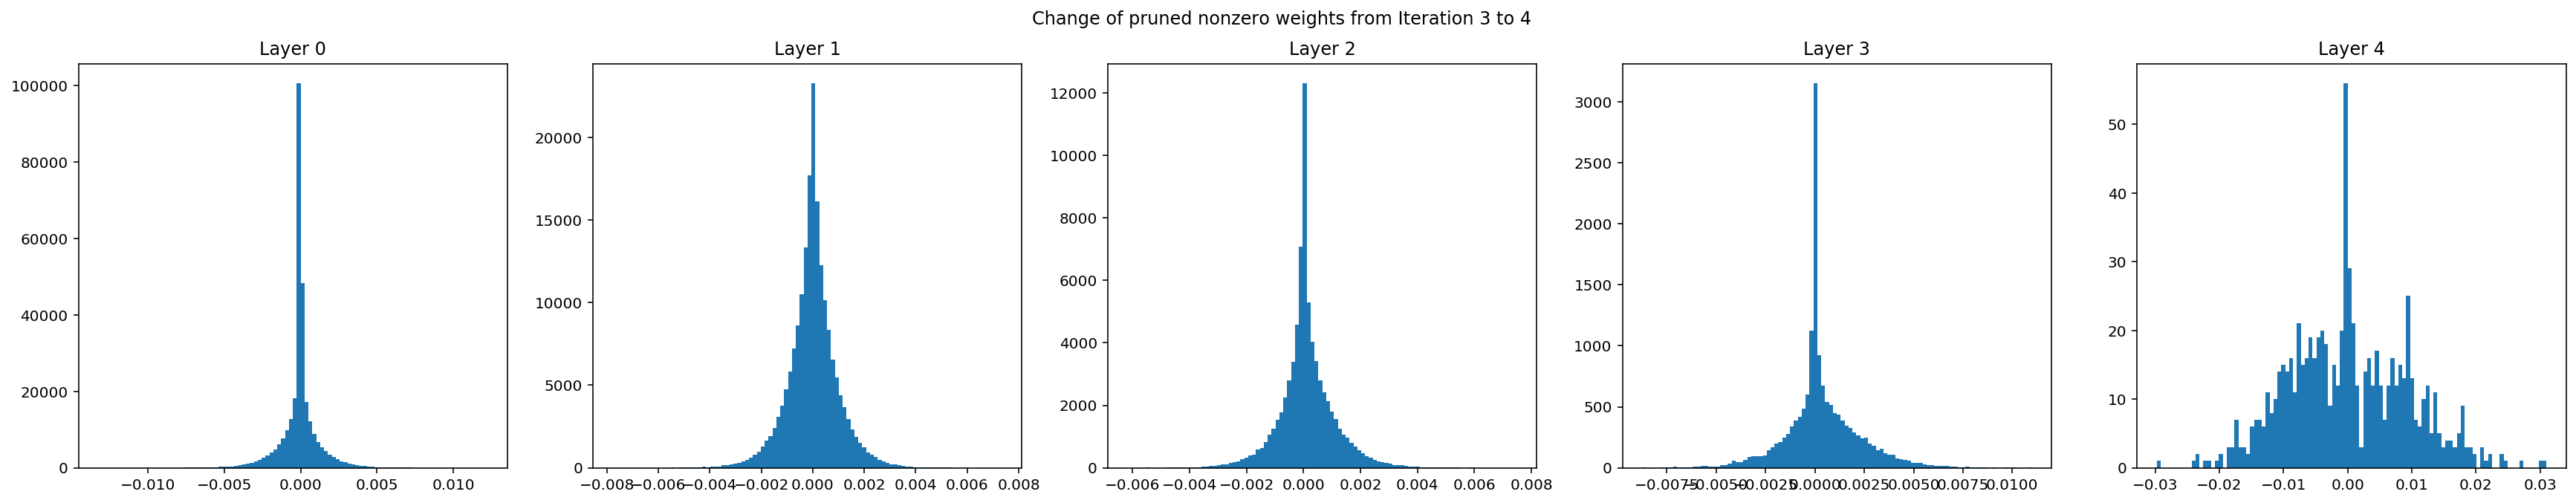

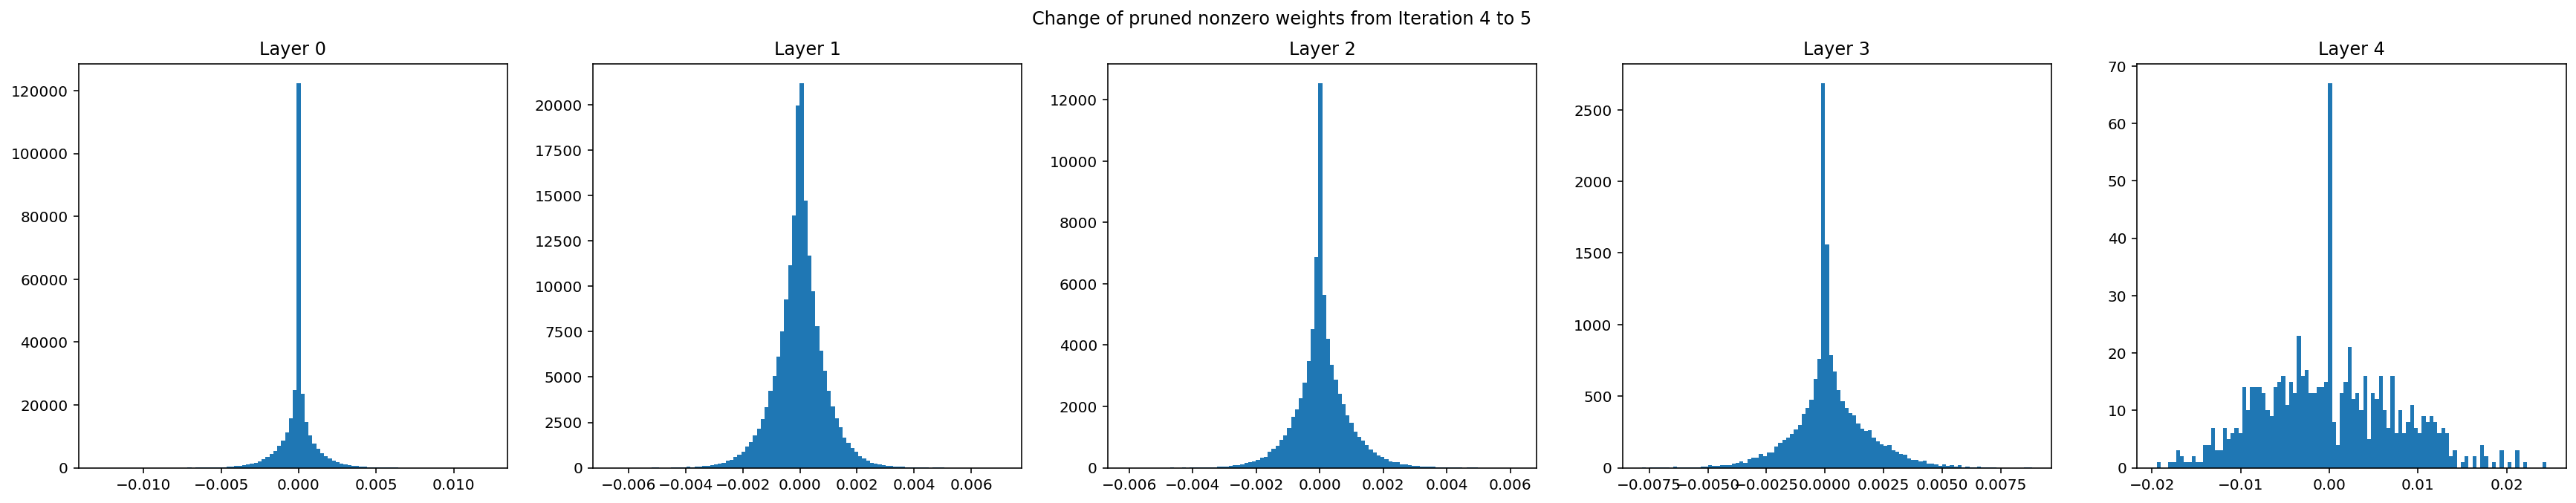

In [168]:
for i,all_weights_iter in enumerate(delta_to_prior_layer_nonzero):
    fig = plt.figure(figsize=(30,5))
    fig.suptitle(f"Change of pruned nonzero weights from Iteration {i} to {i+1}")
    for j,all_weights_layer in enumerate (all_weights_iter):
        plt.subplot(1,5,j+1)
        plt.title(f"Layer {j}")
        _ = plt.hist(all_weights_layer.flatten(), bins=100)

In [107]:
def count_weights(model):
    return np.sum([l.count_params() - l.units for l in model.layers])

def count_masked_weights(model):
    return tf.reduce_sum([tf.math.count_nonzero(l.get_masked_weights()) for l in fcn.layers]).numpy()

def layerwise_pruning_p(model):
    for i,l in enumerate(model.layers):
        total = l.count_params() - l.units
        masked = tf.math.count_nonzero(l.get_masked_weights())
        print(f"{((total-masked)/total) * 100}% of Layer {i} weights are pruned")

In [171]:
layerwise_pruning_p(fcn)

66.06231778425656% of Layer 0 weights are pruned
65.81658163265305% of Layer 1 weights are pruned
65.194% of Layer 2 weights are pruned
60.45666666666667% of Layer 3 weights are pruned
30.4% of Layer 4 weights are pruned


In [172]:
count_masked_weights(fcn) / count_weights(fcn)

0.34300083525869446

In [84]:
def get_margin_min_weights(weights, th=0.2):
    w_shape = weights.shape[0]
    #idx_weights_sorted = np.absolute(weights).argsort()
    weights_sorted = np.sort(np.absolute(weights))
    
    weights_sorted_zeros_idx = np.where(weights_sorted == 0.)[0]
    weights_sorted_nonzero_idx = np.where(weights_sorted != 0.)[0]
    
    #Array with argsort is sorted, so only the count of zero and non-zero indices is important. 
    #To maintain the same shape for every array, count of zeros is added on top of the pruning ratio
    
    return np.absolute(weights).argsort()[:int(weights_sorted_zeros_idx.shape[0] + weights_sorted_nonzero_idx.shape[0]*th)]

def get_margin_max_weights(weights, th=0.8):
    w_shape = weights.shape[0]
    return np.absolute(weights).argsort()[::-1][:int(w_shape*th)]

def get_p_smallest_value(weights, p, absolute=True):
    w_shape = weights.shape[0]

    if absolute:
        weights_sorted = np.sort(np.absolute(weights))
        weights_sorted_zeros_idx = np.where(weights_sorted == 0.)[0]
        weights_sorted_nonzero_idx = np.where(weights_sorted != 0.)[0]
        
        return np.sort(np.absolute(weights))[int(weights_sorted_zeros_idx.shape[0] + weights_sorted_nonzero_idx.shape[0]*p)]

In [85]:
def get_global_neuron_position(idx, model):
    no_layers = len(model.layers)
    no_neurons = [l.units for l in model.layers]
    # number of weights in a layer without bias
    no_weights = [l.count_params() - l.units for l in model.layers]
    print(no_neurons)
    total_no_weights = np.sum(no_neurons)
    return total_weights
    

In [86]:
def mask_layerwise(model, th=0.8, get_ones=True):
    for l in model.layers:
        weights_shape = l.get_masked_weights().shape
        weights_flat = l.get_masked_weights().numpy().flatten()
        
        old_mask = l.get_mask()

        if get_ones:
            mask = np.zeros(weights_shape)
            idx_mask_flat = get_margin_max_weights(weights_flat, th)
        else:
            mask = np.ones(weights_shape)
            idx_mask_flat = get_margin_min_weights(weights_flat, th)

        idx_mask_unrav = np.unravel_index(idx_mask_flat, weights_shape)
        idx_mask_orig = [list(i) for i in zip(idx_mask_unrav[0], idx_mask_unrav[1])]

        if get_ones:
            mask[idx_mask_unrav] = 1.
        else:
            mask[idx_mask_unrav] = 0.
        
        if get_ones:
            mask = np.logical_or(old_mask,mask).astype("float32")
        else:
            mask = np.logical_and(old_mask,mask).astype("float32")
        l.set_mask(mask)
    return model

In [251]:
fcn = mask_layerwise(fcn,th=0.2,get_ones=False)

In [89]:
def mask_globally(model, th=0.5):
    shape_info = [l.weights[0].shape for l in model.layers]
    all_weights_flat = np.concatenate([l.get_masked_weights().numpy().flatten() for l in model.layers])
    
    mask = np.ones(all_weights_flat.shape)
    
    p_val = get_p_smallest_value(all_weights_flat, p=th)
    print(p_val)
    all_weights_smaller_p = np.where(np.absolute(all_weights_flat) < p_val)[0]
    
    mask[all_weights_smaller_p] = 0
    
    for i,s in enumerate(shape_info):
        print(i,s)
        print("Mask shape: ", mask.shape)
        old_mask = model.layers[i].get_mask()
        layer_mask = mask[:s[0]*s[1]].reshape(s)
        layer_mask = np.logical_and(old_mask,layer_mask).astype("float32")
        print(layer_mask.shape)
        model.layers[i].set_mask(layer_mask)
        mask = mask[s[0]*s[1]:]
    
    return model

In [170]:
fcn = mask_globally(fcn, th=0.3)

0.048231676
0 (784, 784)
Mask shape:  (1187656,)
(784, 784)
1 (784, 500)
Mask shape:  (573000,)
(784, 500)
2 (500, 300)
Mask shape:  (181000,)
(500, 300)
3 (300, 100)
Mask shape:  (31000,)
(300, 100)
4 (100, 10)
Mask shape:  (1000,)
(100, 10)


In [156]:
def get_layer_neuron_position(original_shape, idx):
    row = flattened_shape // idx
    col = flattened_shape % idx
    return row,col

In [ ]:
get_layer_neuron_position()

In [75]:
count_weights(fcn)

1437656

In [70]:
get_neuron_position(1, fcn)

[614656, 392000, 250000, 150000, 30000, 1000]


1437656

In [33]:
np.absolute(all_weights_flat).argsort()[:3]

array([400413, 232210, 588631], dtype=int64)

In [34]:
all_weights_flat[np.absolute(all_weights_flat).argsort()[:3]]

array([8.0100790e-08, 1.3837587e-07, 2.1931491e-07], dtype=float32)

In [30]:
all_weights_flat[all_weights_flat.argsort()[:3]]#[::-1]

AttributeError: 'numpy.ndarray' object has no attribute 'absolute'

In [27]:
fcn.layers[0].variables[0].numpy().flatten().argsort()[:3]

array([340864, 230706, 340080], dtype=int64)

In [204]:
tf.math.argmax(fcn.predict(ds_test),axis=1).numpy()

array([8, 9, 9, ..., 8, 6, 3], dtype=int64)

In [31]:
fcn.weights[0]

<tf.Variable 'fcn/dense/kernel:0' shape=(784, 784) dtype=float32, numpy=
array([[ 0.00320148, -0.01827742,  0.06130352, ...,  0.04060205,
         0.02379157, -0.03781855],
       [ 0.00195461, -0.04731672,  0.02820133, ...,  0.01904944,
         0.0046684 , -0.0160788 ],
       [-0.04681788,  0.05586999,  0.01616797, ...,  0.04487784,
        -0.036598  ,  0.05946429],
       ...,
       [ 0.03616958,  0.05537617,  0.05029987, ..., -0.04570258,
        -0.04829326, -0.02737596],
       [ 0.02342445,  0.03788621, -0.04843409, ..., -0.00373795,
         0.05040981,  0.05115459],
       [-0.0306081 ,  0.04366313,  0.00997305, ...,  0.04759349,
         0.02772474,  0.01498207]], dtype=float32)>

In [25]:
[v for v in FCN.trainable_variables()]

TypeError: 'property' object is not callable